In [1]:
# ============================================================
# Projeto A1 — Starter de Modelagem (carrega do FREEZE_DIR)
# ============================================================
import os, re, json, joblib, numpy as np, pandas as pd
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# -------- paths --------
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD    = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_FEATS_SILVER2 = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_silver2.csv")  # opcional
PATH_SPLITS        = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_IMPUTER       = os.path.join(FREEZE_DIR, "imputer_gold_median.joblib")
PATH_SCALER        = os.path.join(FREEZE_DIR, "scaler_gold_standard.joblib")

OUT_MODELS_DIR = os.path.join(FREEZE_DIR, "models")
os.makedirs(OUT_MODELS_DIR, exist_ok=True)

YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]

def read_multiheader_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    dfr = pd.read_csv(path, header=[0,1], engine="python")
    df  = dfr.copy()
    df.columns = [c for (c,_) in dfr.columns]   # usa linha 1 (nomes)
    return df

def to_datetime_guess(df):
    cand = [c for c in df.columns if re.search(r"(time|hora|data|date|timestamp|datetime|ts)", c, re.I)]
    for c in cand:
        s = pd.to_datetime(df[c], errors="coerce", utc=False)
        if s.notna().mean() > 0.9:
            return s, c
    return None, None

# -------- 1) carregar GOLD --------
df = read_multiheader_csv(PATH_FEATS_GOLD)
assert all(c in df.columns for c in YCOLS), "Alvos ausentes no GOLD."
print(f"[GOLD] shape: {df.shape}")

# -------- 2) criar/ler splits temporais 70/10/20 --------
if os.path.exists(PATH_SPLITS):
    splits = joblib.load(PATH_SPLITS)
    print("[splits] carregados de arquivo.")
else:
    n = len(df)
    idx = np.arange(n)  # assume ordenação temporal já no CSV
    train_end = int(0.7*n); val_end = int(0.8*n)
    splits = {
        "train": idx[:train_end].tolist(),
        "val":   idx[train_end:val_end].tolist(),
        "test":  idx[val_end:].tolist(),
    }
    joblib.dump(splits, PATH_SPLITS)
    print("[splits] criados e salvos.")

# -------- 3) montar X/Y e pipeline (imputer + scaler) --------
X_all = df.drop(columns=YCOLS).select_dtypes(include=[np.number])
y_all = df[YCOLS].apply(pd.to_numeric, errors="coerce")

idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]
X_tr, X_va, X_te = X_all.iloc[idx_tr], X_all.iloc[idx_va], X_all.iloc[idx_te]
y_tr, y_va, y_te = y_all.iloc[idx_tr].values, y_all.iloc[idx_va].values, y_all.iloc[idx_te].values

if os.path.exists(PATH_IMPUTER) and os.path.exists(PATH_SCALER):
    imp = joblib.load(PATH_IMPUTER)
    sc  = joblib.load(PATH_SCALER)
    print("[pipeline] imputer/scaler carregados.")
else:
    imp = SimpleImputer(strategy="median")
    sc  = StandardScaler()
    X_tr_fit = imp.fit_transform(X_tr)
    sc.fit(X_tr_fit)
    joblib.dump(imp, PATH_IMPUTER)
    joblib.dump(sc,  PATH_SCALER)
    print("[pipeline] imputer/scaler treinados e salvos.")

X_tr_p = sc.transform(imp.transform(X_tr))
X_va_p = sc.transform(imp.transform(X_va))
X_te_p = sc.transform(imp.transform(X_te))

# -------- 4) baseline rápido (RF multi-alvo) --------
model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=400, random_state=42, n_jobs=-1
))
model.fit(X_tr_p, y_tr)

def metrics(y_true, y_pred):
    out = {}
    for i, col in enumerate(YCOLS):
        out[col] = {"R2": float(r2_score(y_true[:,i], y_pred[:,i])),
                    "MAE": float(mean_absolute_error(y_true[:,i], y_pred[:,i]))}
    return out

pred_va = model.predict(X_va_p)
pred_te = model.predict(X_te_p)
m_val   = metrics(y_va, pred_va)
m_test  = metrics(y_te, pred_te)

ts = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_PATH = os.path.join(OUT_MODELS_DIR, f"rf_gold_{ts}.joblib")
joblib.dump({"model": model, "imputer": imp, "scaler": sc,
             "feature_names": X_all.columns.tolist(),
             "y_names": YCOLS}, MODEL_PATH)

print("\n=== BASELINE RF (GOLD) ===")
print("VAL:", m_val)
print("TST:", m_test)
print("modelo salvo em:", MODEL_PATH)

# -------- (opcional) carregar SILVER2 e repetir apenas se desejar --------
if os.path.exists(PATH_FEATS_SILVER2):
    df_s2 = read_multiheader_csv(PATH_FEATS_SILVER2)
    print(f"[SILVER2] shape: {df_s2.shape}  (use como conjunto de robustez)")


[GOLD] shape: (10005, 147)
[splits] carregados de arquivo.
[pipeline] imputer/scaler carregados.

=== BASELINE RF (GOLD) ===
VAL: {'wr_kg_m2_h': {'R2': 0.9307405554581266, 'MAE': 5.3710211866290645e-08}, 'wm_kg_m2_h': {'R2': 0.9251247772044555, 'MAE': 26756.00187413825}}
TST: {'wr_kg_m2_h': {'R2': 0.7555313839613604, 'MAE': 1.0838959098182044e-07}, 'wm_kg_m2_h': {'R2': 0.6977987427390622, 'MAE': 58664.260830891195}}
modelo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\rf_gold_20250818_0826.joblib
[SILVER2] shape: (11749, 147)  (use como conjunto de robustez)


In [2]:
# ============================================================
# TABELA DE MÉTRICAS POR SPLIT (GOLD) - AUTOSSUFICIENTE (fix RMSE)
# ============================================================
import os, joblib, numpy as np, pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import iqr

# -------- paths --------
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
MODELS_DIR      = os.path.join(FREEZE_DIR, "models")

# pega o modelo mais recente por data de modificação
model_file = max(
    [os.path.join(MODELS_DIR, f) for f in os.listdir(MODELS_DIR) if f.endswith(".joblib")],
    key=lambda p: os.path.getmtime(p)
)

YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]

# -------- carregar dados --------
df_raw = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
df = df_raw.copy()
df.columns = [c for (c,_) in df_raw.columns]   # usa só a linha 1 (nomes)

X_all = df.drop(columns=YCOLS).select_dtypes(include=[np.number])
y_all = df[YCOLS].apply(pd.to_numeric, errors="coerce").values

# Coluna temporal (primeira, 'timestamp')
tempo_col = pd.to_datetime(df.iloc[:,0], errors="coerce")

# -------- carregar splits + modelo/pipeline --------
splits = joblib.load(PATH_SPLITS)
pack   = joblib.load(model_file)
model  = pack["model"]
imp    = pack["imputer"]
sc     = pack["scaler"]

# -------- preparar X/Y já transformados --------
idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]
X_tr_p = sc.transform(imp.transform(X_all.iloc[idx_tr]))
X_va_p = sc.transform(imp.transform(X_all.iloc[idx_va]))
X_te_p = sc.transform(imp.transform(X_all.iloc[idx_te]))
y_tr, y_va, y_te = y_all[idx_tr], y_all[idx_va], y_all[idx_te]

# -------- funções de métricas --------
def mae_iqr(y_true, y_pred):
    e = np.abs(y_true - y_pred)
    denom = iqr(y_true) or 1.0
    return float(np.mean(e) / denom)

def resumo_split(nome, idx, y, pred, tempo_col):
    r = {"split": nome, "linhas": len(idx)}
    s = tempo_col.iloc[idx]
    r["inicio"] = str(pd.to_datetime(s.min()))
    r["fim"]    = str(pd.to_datetime(s.max()))
    for j, alvo in enumerate(YCOLS):
        yt, yp = y[:,j], pred[:,j]
        r[f"R2_{alvo}"]       = float(r2_score(yt, yp))
        r[f"RMSE_{alvo}"]     = float(mean_squared_error(yt, yp) ** 0.5)  # <= sem 'squared'
        r[f"MAE_{alvo}"]      = float(mean_absolute_error(yt, yp))
        r[f"MAE_IQR_{alvo}"]  = mae_iqr(yt, yp)
    return r

# -------- gerar previsões --------
pred_tr = model.predict(X_tr_p)
pred_va = model.predict(X_va_p)
pred_te = model.predict(X_te_p)

# -------- montar tabela --------
res = []
res.append(resumo_split("treino", idx_tr, y_tr, pred_tr, tempo_col))
res.append(resumo_split("validacao", idx_va, y_va, pred_va, tempo_col))
res.append(resumo_split("teste", idx_te, y_te, pred_te, tempo_col))
df_res = pd.DataFrame(res)

# -------- salvar e mostrar --------
out_csv = os.path.join(FREEZE_DIR, "metrics_splits_gold.csv")
df_res.to_csv(out_csv, index=False, encoding="utf-8")
print("✅ Tabela salva em:", out_csv)
print("Modelo utilizado:", model_file)

import IPython.display as disp
disp.display(df_res)


✅ Tabela salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_splits_gold.csv
Modelo utilizado: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\rf_gold_20250818_0826.joblib


,split,linhas,inicio,fim,R2_wr_kg_m2_h,RMSE_wr_kg_m2_h,MAE_wr_kg_m2_h,MAE_IQR_wr_kg_m2_h,R2_wm_kg_m2_h,RMSE_wm_kg_m2_h,MAE_wm_kg_m2_h,MAE_IQR_wm_kg_m2_h
0,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,0.981005,1.812962e-08,4.952395e-09,4.952395e-09,0.995618,3960.890856,510.927028,510.927028
1,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,0.930741,1.020362e-07,5.371021e-08,9.383454e-02,0.925125,55223.642761,26756.001874,0.076794
2,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,0.755531,1.925338e-07,1.083896e-07,2.439133e-01,0.697799,99333.185646,58664.260831,0.209556


In [3]:
# ============================================================
# MÉTRICAS POR SPLIT — GOLD e SILVER2 (comparativo)
# Usa o modelo/pipeline treinado no GOLD
# ============================================================
import os, joblib, numpy as np, pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import iqr

# -------- paths --------
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD    = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_FEATS_SILVER2 = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_silver2.csv")
PATH_SPLITS_GOLD   = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
MODELS_DIR         = os.path.join(FREEZE_DIR, "models")

# modelo mais recente
model_file = max(
    [os.path.join(MODELS_DIR, f) for f in os.listdir(MODELS_DIR) if f.endswith(".joblib")],
    key=lambda p: os.path.getmtime(p)
)

YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]

def mae_iqr(y_true, y_pred):
    e = np.abs(y_true - y_pred)
    denom = iqr(y_true) or 1.0
    return float(np.mean(e) / denom)

def resumo_split(dataset, nome, idx, y, pred, tempo_col):
    r = {"dataset": dataset, "split": nome, "linhas": len(idx)}
    s = tempo_col.iloc[idx]
    r["inicio"] = str(pd.to_datetime(s.min()))
    r["fim"]    = str(pd.to_datetime(s.max()))
    for j, alvo in enumerate(YCOLS):
        yt, yp = y[:,j], pred[:,j]
        r[f"R2_{alvo}"]       = float(r2_score(yt, yp))
        r[f"RMSE_{alvo}"]     = float(mean_squared_error(yt, yp) ** 0.5)
        r[f"MAE_{alvo}"]      = float(mean_absolute_error(yt, yp))
        r[f"MAE_IQR_{alvo}"]  = mae_iqr(yt, yp)
    return r

def carrega_df(path_csv):
    dfr = pd.read_csv(path_csv, header=[0,1], engine="python")
    df  = dfr.copy()
    df.columns = [c for (c,_) in dfr.columns]   # usa 1ª linha (nomes)
    # tempo = primeira coluna (timestamp)
    tempo_col = pd.to_datetime(df.iloc[:,0], errors="coerce")
    X_all = df.drop(columns=YCOLS).select_dtypes(include=[np.number])
    y_all = df[YCOLS].apply(pd.to_numeric, errors="coerce").values
    return df, tempo_col, X_all, y_all

def split_701020(n):
    idx = np.arange(n)
    train_end = int(0.7*n); val_end = int(0.8*n)
    return idx[:train_end], idx[train_end:val_end], idx[val_end:]

# -------- carrega modelo/pipeline (GOLD) --------
pack   = joblib.load(model_file)
model  = pack["model"]
imp    = pack["imputer"]
sc     = pack["scaler"]

# =================== GOLD ===================
df_g, tempo_g, Xg_all, yg_all = carrega_df(PATH_FEATS_GOLD)
if os.path.exists(PATH_SPLITS_GOLD):
    splits_g = joblib.load(PATH_SPLITS_GOLD)
    idxg_tr, idxg_va, idxg_te = splits_g["train"], splits_g["val"], splits_g["test"]
else:
    idxg_tr, idxg_va, idxg_te = split_701020(len(df_g))

Xg_tr_p = sc.transform(imp.transform(Xg_all.iloc[idxg_tr]))
Xg_va_p = sc.transform(imp.transform(Xg_all.iloc[idxg_va]))
Xg_te_p = sc.transform(imp.transform(Xg_all.iloc[idxg_te]))
yg_tr, yg_va, yg_te = yg_all[idxg_tr], yg_all[idxg_va], yg_all[idxg_te]

predg_tr = model.predict(Xg_tr_p)
predg_va = model.predict(Xg_va_p)
predg_te = model.predict(Xg_te_p)

rows_gold = []
rows_gold.append(resumo_split("GOLD", "treino",    idxg_tr, yg_tr, predg_tr, tempo_g))
rows_gold.append(resumo_split("GOLD", "validacao", idxg_va, yg_va, predg_va, tempo_g))
rows_gold.append(resumo_split("GOLD", "teste",     idxg_te, yg_te, predg_te, tempo_g))
df_gold = pd.DataFrame(rows_gold)

# =================== SILVER2 ===================
if os.path.exists(PATH_FEATS_SILVER2):
    df_s, tempo_s, Xs_all, ys_all = carrega_df(PATH_FEATS_SILVER2)
    idxs_tr, idxs_va, idxs_te = split_701020(len(df_s))  # split próprio do SILVER2

    Xs_tr_p = sc.transform(imp.transform(Xs_all.iloc[idxs_tr]))
    Xs_va_p = sc.transform(imp.transform(Xs_all.iloc[idxs_va]))
    Xs_te_p = sc.transform(imp.transform(Xs_all.iloc[idxs_te]))
    ys_tr, ys_va, ys_te = ys_all[idxs_tr], ys_all[idxs_va], ys_all[idxs_te]

    preds_tr = model.predict(Xs_tr_p)
    preds_va = model.predict(Xs_va_p)
    preds_te = model.predict(Xs_te_p)

    rows_silver = []
    rows_silver.append(resumo_split("SILVER2", "treino",    idxs_tr, ys_tr, preds_tr, tempo_s))
    rows_silver.append(resumo_split("SILVER2", "validacao", idxs_va, ys_va, preds_va, tempo_s))
    rows_silver.append(resumo_split("SILVER2", "teste",     idxs_te, ys_te, preds_te, tempo_s))
    df_silver = pd.DataFrame(rows_silver)
else:
    df_silver = pd.DataFrame(columns=["dataset","split","linhas","inicio","fim"] +
        [m for y in YCOLS for m in (f"R2_{y}",f"RMSE_{y}",f"MAE_{y}",f"MAE_IQR_{y}")])

# -------- salvar saídas --------
csv_gold       = os.path.join(FREEZE_DIR, "metrics_splits_gold.csv")
csv_silver2    = os.path.join(FREEZE_DIR, "metrics_splits_silver2.csv")
csv_comparado  = os.path.join(FREEZE_DIR, "metrics_splits_gold_silver2.csv")

df_gold.to_csv(csv_gold, index=False, encoding="utf-8")
df_silver.to_csv(csv_silver2, index=False, encoding="utf-8") if not df_silver.empty else None
pd.concat([df_gold, df_silver], axis=0, ignore_index=True).to_csv(csv_comparado, index=False, encoding="utf-8")

print("Saídas geradas:")
print(" -", csv_gold)
if not df_silver.empty:
    print(" -", csv_silver2)
    print(" -", csv_comparado)
else:
    print(" - SILVER2 não encontrado ou vazio; gerado apenas GOLD.")

import IPython.display as disp
disp.display(df_gold)
if not df_silver.empty:
    disp.display(df_silver)


Saídas geradas:
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_splits_gold.csv
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_splits_silver2.csv
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_splits_gold_silver2.csv


,dataset,split,linhas,inicio,fim,R2_wr_kg_m2_h,RMSE_wr_kg_m2_h,MAE_wr_kg_m2_h,MAE_IQR_wr_kg_m2_h,R2_wm_kg_m2_h,RMSE_wm_kg_m2_h,MAE_wm_kg_m2_h,MAE_IQR_wm_kg_m2_h
0,GOLD,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,0.981005,1.812962e-08,4.952395e-09,4.952395e-09,0.995618,3960.890856,510.927028,510.927028
1,GOLD,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,0.930741,1.020362e-07,5.371021e-08,9.383454e-02,0.925125,55223.642761,26756.001874,0.076794
2,GOLD,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,0.755531,1.925338e-07,1.083896e-07,2.439133e-01,0.697799,99333.185646,58664.260831,0.209556


,dataset,split,linhas,inicio,fim,R2_wr_kg_m2_h,RMSE_wr_kg_m2_h,MAE_wr_kg_m2_h,MAE_IQR_wr_kg_m2_h,R2_wm_kg_m2_h,RMSE_wm_kg_m2_h,MAE_wm_kg_m2_h,MAE_IQR_wm_kg_m2_h
0,SILVER2,treino,8224,2023-03-01 07:00:00,2024-07-02 04:00:00,0.881788,5.396967e-08,1.629371e-08,530.784198,0.954886,19377.270121,4729.759171,732.917386
1,SILVER2,validacao,1175,2024-07-02 05:00:00,2024-08-20 03:00:00,0.561053,1.768687e-07,9.370144e-08,0.268794,0.822485,63210.129874,34975.882976,0.143103
2,SILVER2,teste,2350,2024-08-20 04:00:00,2024-12-27 01:00:00,-0.445821,3.579265e-07,2.242963e-07,0.763883,0.621059,93712.918447,66286.955487,0.308281


In [4]:
# ============================================================
# Utilidades para loader, métricas e resumo por split (GOLD)
# ============================================================
import os, joblib, numpy as np, pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import iqr

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_IMPUTER    = os.path.join(FREEZE_DIR, "imputer_gold_median.joblib")
PATH_SCALER     = os.path.join(FREEZE_DIR, "scaler_gold_standard.joblib")

os.makedirs(os.path.join(FREEZE_DIR, "models"), exist_ok=True)

def load_gold_xy(target_col):
    # Lê CSV com 2 cabeçalhos, usa só a 1ª linha (nomes)
    dfr = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
    df  = dfr.copy()
    df.columns = [c for (c,_) in dfr.columns]

    # timestamp = primeira coluna
    tempo_col = pd.to_datetime(df.iloc[:,0], errors="coerce")

    # X = numéricas (sem os alvos), y = alvo único
    ycols = ["wr_kg_m2_h","wm_kg_m2_h"]
    if target_col not in ycols:
        raise ValueError(f"Alvo inválido: {target_col}. Use {ycols}.")
    X_all = df.drop(columns=ycols).select_dtypes(include=[np.number])
    y_all = pd.to_numeric(df[target_col], errors="coerce").values.reshape(-1, 1)

    # splits temporais
    splits = joblib.load(PATH_SPLITS)
    idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]

    # pipeline (imputer+scaler) do GOLD
    imp = joblib.load(PATH_IMPUTER)
    sc  = joblib.load(PATH_SCALER)
    X_tr_p = sc.transform(imp.transform(X_all.iloc[idx_tr]))
    X_va_p = sc.transform(imp.transform(X_all.iloc[idx_va]))
    X_te_p = sc.transform(imp.transform(X_all.iloc[idx_te]))
    y_tr, y_va, y_te = y_all[idx_tr], y_all[idx_va], y_all[idx_te]

    return {
        "df": df,
        "tempo": tempo_col,
        "X_tr_p": X_tr_p, "X_va_p": X_va_p, "X_te_p": X_te_p,
        "y_tr": y_tr, "y_va": y_va, "y_te": y_te,
        "idx_tr": idx_tr, "idx_va": idx_va, "idx_te": idx_te,
        "imp": imp, "sc": sc
    }

def mae_iqr(y_true, y_pred):
    e = np.abs(y_true - y_pred).ravel()
    denom = iqr(y_true.ravel())
    if not np.isfinite(denom) or denom == 0.0:
        denom = 1.0
    return float(np.mean(e) / denom)

def resumo_split(nome, idx, y, pred, tempo_col, alvo_name):
    r = {"split": nome, "linhas": len(idx)}
    s = tempo_col.iloc[idx]
    r["inicio"] = str(pd.to_datetime(s.min()))
    r["fim"]    = str(pd.to_datetime(s.max()))
    yt, yp = y.ravel(), pred.ravel()
    r[f"R2_{alvo_name}"]      = float(r2_score(yt, yp))
    r[f"RMSE_{alvo_name}"]    = float(mean_squared_error(yt, yp) ** 0.5)
    r[f"MAE_{alvo_name}"]     = float(mean_absolute_error(yt, yp))
    r[f"MAE_IQR_{alvo_name}"] = float(mae_iqr(yt, yp))
    return r

def now_tag():
    return datetime.now().strftime("%Y%m%d_%H%M")


In [5]:
# ============================================================
# Treino e avaliação: modelo dedicado para Wr (GOLD)
# ============================================================
import os, joblib, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor

target = "wr_kg_m2_h"
bundle = load_gold_xy(target)
tempo = bundle["tempo"]

# Modelo
rf_wr = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf_wr.fit(bundle["X_tr_p"], bundle["y_tr"].ravel())

# Previsões
pred_tr = rf_wr.predict(bundle["X_tr_p"]).reshape(-1,1)
pred_va = rf_wr.predict(bundle["X_va_p"]).reshape(-1,1)
pred_te = rf_wr.predict(bundle["X_te_p"]).reshape(-1,1)

# Tabela de métricas
rows = []
rows.append(resumo_split("treino", bundle["idx_tr"], bundle["y_tr"], pred_tr, tempo, target))
rows.append(resumo_split("validacao", bundle["idx_va"], bundle["y_va"], pred_va, tempo, target))
rows.append(resumo_split("teste", bundle["idx_te"], bundle["y_te"], pred_te, tempo, target))
df_wr = pd.DataFrame(rows)

# Salvar métricas e modelo
csv_wr = os.path.join(FREEZE_DIR, "metrics_wr_gold.csv")
df_wr.to_csv(csv_wr, index=False, encoding="utf-8")

model_path_wr = os.path.join(FREEZE_DIR, "models", f"rf_wr_gold_{now_tag()}.joblib")
joblib.dump({
    "model": rf_wr,
    "imputer": bundle["imp"],
    "scaler":  bundle["sc"],
    "target":  target
}, model_path_wr)

print("Métricas Wr salvas em:", csv_wr)
print("Modelo Wr salvo em:", model_path_wr)
display(df_wr)


Métricas Wr salvas em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_wr_gold.csv
Modelo Wr salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\rf_wr_gold_20250818_0826.joblib


,split,linhas,inicio,fim,R2_wr_kg_m2_h,RMSE_wr_kg_m2_h,MAE_wr_kg_m2_h,MAE_IQR_wr_kg_m2_h
0,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,0.981005,1.812962e-08,4.952395e-09,4.952395e-09
1,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,0.930741,1.020362e-07,5.371021e-08,9.383454e-02
2,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,0.755531,1.925338e-07,1.083896e-07,2.439133e-01


In [6]:
# ============================================================
# Treino e avaliação: modelos dedicados para Wm (direto e log1p)
# ============================================================
import os, joblib, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor

target = "wm_kg_m2_h"
bundle = load_gold_xy(target)
tempo = bundle["tempo"]

# Modelo direto em Wm
rf_wm_direct = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf_wm_direct.fit(bundle["X_tr_p"], bundle["y_tr"].ravel())

pred_tr_dir = rf_wm_direct.predict(bundle["X_tr_p"]).reshape(-1,1)
pred_va_dir = rf_wm_direct.predict(bundle["X_va_p"]).reshape(-1,1)
pred_te_dir = rf_wm_direct.predict(bundle["X_te_p"]).reshape(-1,1)

# Modelo em log1p(Wm)
y_tr_log = np.log1p(bundle["y_tr"])
rf_wm_log = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf_wm_log.fit(bundle["X_tr_p"], y_tr_log.ravel())

# previsões no espaço do log e retorno ao original com expm1
pred_tr_log = np.expm1(rf_wm_log.predict(bundle["X_tr_p"]).reshape(-1,1))
pred_va_log = np.expm1(rf_wm_log.predict(bundle["X_va_p"]).reshape(-1,1))
pred_te_log = np.expm1(rf_wm_log.predict(bundle["X_te_p"]).reshape(-1,1))

# Tabelas de métricas
rows = []
rows.append({"variante":"direto", **resumo_split("treino", bundle["idx_tr"], bundle["y_tr"], pred_tr_dir, tempo, target)})
rows.append({"variante":"direto", **resumo_split("validacao", bundle["idx_va"], bundle["y_va"], pred_va_dir, tempo, target)})
rows.append({"variante":"direto", **resumo_split("teste", bundle["idx_te"], bundle["y_te"], pred_te_dir, tempo, target)})

rows.append({"variante":"log1p", **resumo_split("treino", bundle["idx_tr"], bundle["y_tr"], pred_tr_log, tempo, target)})
rows.append({"variante":"log1p", **resumo_split("validacao", bundle["idx_va"], bundle["y_va"], pred_va_log, tempo, target)})
rows.append({"variante":"log1p", **resumo_split("teste", bundle["idx_te"], bundle["y_te"], pred_te_log, tempo, target)})

df_wm = pd.DataFrame(rows)

# Salvar métricas e modelos
csv_wm = os.path.join(FREEZE_DIR, "metrics_wm_gold.csv")
df_wm.to_csv(csv_wm, index=False, encoding="utf-8")

mp_dir = os.path.join(FREEZE_DIR, "models", f"rf_wm_direct_gold_{now_tag()}.joblib")
mp_log = os.path.join(FREEZE_DIR, "models", f"rf_wm_log1p_gold_{now_tag()}.joblib")
joblib.dump({"model": rf_wm_direct, "imputer": bundle["imp"], "scaler": bundle["sc"], "target": target, "variant":"direct"}, mp_dir)
joblib.dump({"model": rf_wm_log,    "imputer": bundle["imp"], "scaler": bundle["sc"], "target": target, "variant":"log1p"}, mp_log)

print("Métricas Wm salvas em:", csv_wm)
print("Modelos Wm salvos em:")
print(" -", mp_dir)
print(" -", mp_log)

# Visualização: comparação por split e variante
display(df_wm)


Métricas Wm salvas em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_wm_gold.csv
Modelos Wm salvos em:
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\rf_wm_direct_gold_20250818_0827.joblib
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\rf_wm_log1p_gold_20250818_0827.joblib


,variante,split,linhas,inicio,fim,R2_wm_kg_m2_h,RMSE_wm_kg_m2_h,MAE_wm_kg_m2_h,MAE_IQR_wm_kg_m2_h
0,direto,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,0.995618,3960.890856,510.927028,510.927028
1,direto,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,0.925125,55223.642761,26756.001874,0.076794
2,direto,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,0.697799,99333.185646,58664.260831,0.209556
3,log1p,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,0.994736,4341.245691,535.708024,535.708024
4,log1p,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,0.889678,67032.660289,31794.807533,0.091256
5,log1p,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,0.534389,123298.552773,73682.540041,0.263204


In [7]:
# ============================================================
# Consolidação das métricas em um único CSV
# ============================================================
import os, pandas as pd

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
csv_wr = os.path.join(FREEZE_DIR, "metrics_wr_gold.csv")
csv_wm = os.path.join(FREEZE_DIR, "metrics_wm_gold.csv")

df_wr = pd.read_csv(csv_wr)
df_wr.insert(0, "dataset", "GOLD")
df_wr.insert(1, "alvo", "wr_kg_m2_h")
df_wr.insert(2, "variante", "direto")

df_wm = pd.read_csv(csv_wm)
# df_wm já tem coluna "variante" (direto/log1p) e colunas padronizadas

cols_order = ["dataset","alvo","variante","split","linhas","inicio","fim",
              "R2_wr_kg_m2_h","RMSE_wr_kg_m2_h","MAE_wr_kg_m2_h","MAE_IQR_wr_kg_m2_h",
              "R2_wm_kg_m2_h","RMSE_wm_kg_m2_h","MAE_wm_kg_m2_h","MAE_IQR_wm_kg_m2_h"]

# alinhar colunas (preencher ausentes com NaN)
for c in cols_order:
    if c not in df_wr.columns:
        df_wr[c] = pd.NA
    if c not in df_wm.columns:
        df_wm[c] = pd.NA

df_all = pd.concat([df_wr[cols_order], df_wm[cols_order]], ignore_index=True)
out_csv = os.path.join(FREEZE_DIR, "metrics_wr_wm_gold_consolidado.csv")
df_all.to_csv(out_csv, index=False, encoding="utf-8")

print("Consolidado salvo em:", out_csv)
display(df_all)


Consolidado salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_wr_wm_gold_consolidado.csv


C:\Users\wilso\AppData\Local\Temp\ipykernel_38792\1719724437.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_wr[cols_order], df_wm[cols_order]], ignore_index=True)


,dataset,alvo,variante,split,linhas,inicio,fim,R2_wr_kg_m2_h,RMSE_wr_kg_m2_h,MAE_wr_kg_m2_h,MAE_IQR_wr_kg_m2_h,R2_wm_kg_m2_h,RMSE_wm_kg_m2_h,MAE_wm_kg_m2_h,MAE_IQR_wm_kg_m2_h
0,GOLD,wr_kg_m2_h,direto,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,0.981005,1.812962e-08,4.952395e-09,4.952395e-09,NaN,NaN,NaN,NaN
1,GOLD,wr_kg_m2_h,direto,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,0.930741,1.020362e-07,5.371021e-08,9.383454e-02,NaN,NaN,NaN,NaN
2,GOLD,wr_kg_m2_h,direto,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,0.755531,1.925338e-07,1.083896e-07,2.439133e-01,NaN,NaN,NaN,NaN
3,NaN,NaN,direto,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,NaN,NaN,NaN,NaN,0.995618,3960.890856,510.927028,510.927028
4,NaN,NaN,direto,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,NaN,NaN,NaN,NaN,0.925125,55223.642761,26756.001874,0.076794
5,NaN,NaN,direto,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,NaN,NaN,NaN,NaN,0.697799,99333.185646,58664.260831,0.209556
6,NaN,NaN,log1p,treino,7003,2023-03-01 07:00:00,2024-05-06 16:00:00,NaN,NaN,NaN,NaN,0.994736,4341.245691,535.708024,535.708024
7,NaN,NaN,log1p,validacao,1001,2024-05-06 17:00:00,2024-06-22 00:00:00,NaN,NaN,NaN,NaN,0.889678,67032.660289,31794.807533,0.091256
8,NaN,NaN,log1p,teste,2001,2024-06-22 01:00:00,2024-10-14 10:00:00,NaN,NaN,NaN,NaN,0.534389,123298.552773,73682.540041,0.263204


Ok — direto ao ponto.

# Vale a pena rodar o não supervisionado **agora**?

**Sim, com escopo de diagnóstico.** Ele **não** melhora a métrica por si só, mas antecipa decisões de modelagem e evita ciclos inúteis. Dado que a queda de validação→teste indica **shift temporal** (2024-06→2024-10), um diagnóstico não supervisionado agora tende a esclarecer **o que mudou** no teste e **por quê**.

---

## O que o não supervisionado entrega (e como isso orienta os próximos passos)

1. **Mapeamento de regimes (clusters)**

   * **O que mostra:** se o bloco de teste contém **regimes novos** ou **sub-representados** no treino.
   * **Como usar depois:**

     * Definir **especialistas por regime** (modelos por cluster) ou **pesos** no treino.
     * Ajustar **backtesting** por regimes (não só por fatia temporal).
     * Criar **features** “regime\_id” (one-hot) e **distância-ao-centróide**.

2. **Drift/Shift das distribuições**

   * **O que mostra:** quais features mudaram mais entre **treino/val/teste** (PSI/K-S por feature, PCs ao longo do tempo).
   * **Como usar depois:**

     * Focar engenharia de **lags/janelas** nas variáveis que mais derivam.
     * Guiar a escolha de **modelos mais robustos** (ex.: GBMs) e **regularização**.

3. **Estrutura latente (PCA/Autoencoders)**

   * **O que mostra:** quantas dimensões explicam a maior parte da variância; **combinações físicas** dominantes.
   * **Como usar depois:**

     * PCA scores como features compactas e estáveis.
     * Checar **coerência física** dos loadings e remover ruído/colinearidade residual.

4. **Anomalias/Outliers**

   * **O que mostra:** pontos raros concentrados no **teste** que puxam erro (IsolationForest/LOF/HDBSCAN ruído).
   * **Como usar depois:**

     * Estratégias de **robust loss** (Huber/Quantile) ou **capagem** em features.
     * Filtragem de janelas degradadas (se forem reais defeitos operacionais e não alvo da previsão).

5. **Continuidade temporal dos regimes**

   * **O que mostra:** **trocas de cluster ao longo do tempo**, transições e permanência.
   * **Como usar depois:**

     * Definir **janelas de backtesting** por mudanças de regime (em vez de cortes arbitrários).
     * Introduzir **lags** no entorno das transições (onde o erro aumenta).

> Restrição importante: manter o **leak-guard** — usar **apenas** features não usadas no cálculo dos rótulos.

---

## Vantagens de fazer **agora** (antes de novos supervisionados)

* **Economiza ciclos:** você alinha o pipeline ao que **de fato** mudou no teste.
* **Define CV melhor:** backtesting e/ou *grouped CV* por **regime**, não só por tempo bruto.
* **Engenharia de features focada:** cria lags e agregações onde há **drift real**, e não “no escuro”.
* **Evita conclusões erradas** do split temporal único (um fold só pode ser “acaso”).

## Desvantagens/limitações

* **Não melhora a métrica diretamente.** É diagnóstico.
* **Clusters podem ser instáveis** se você não fixar semente/método; precisa checar **estabilidade** (variação com sementes e subamostras).
* **Risco de “tempo como proxy”:** se padronizar errado, os clusters podem refletir apenas a data. Isso é útil para medir drift, mas ruim como *label* para treinar. Tratar como **sinal de regime**, não como verdade física.

---

## O que esperar de cada trilha (relacionando com o não supervisionado)

* **Manter multi-alvos sem log (baseline atual):**

  * Esperado: métricas atuais em linha, mas **erro cresce em regimes novos**.
  * Com não supervisionado: você identifica **onde** cresce e **por qual conjunto de variáveis**.

* **GBMs para Wm (sem log):**

  * Esperado: ganho em **caudas** e interação.
  * Com não supervisionado: ajuda a **definir monotonicidades locais** e **features/agrupamentos** que estabilizam o aprendizado.

* **Lags/janelas:**

  * Esperado: melhora em transições/efeitos de memória.
  * Com não supervisionado: você adiciona lags **onde** o cluster muda, não em tudo.

* **Backtesting:**

  * Esperado: estimativa honesta de generalização.
  * Com não supervisionado: folds **alinhados a regimes**, medindo estabilidade **entre clusters** (não só no tempo).

---

## Sobre “random 70/10/20” para ganhar assertividade

* Sim, **melhora a métrica** por amostrar mais regimes no treino — mas **não reflete produção** (sempre futuro não visto).
* O uso correto do **random split** aqui é **complementar**: medir **capacidade intrínseca** do modelo, **não** substituir a avaliação temporal.
* Se o random subir muito a métrica enquanto o temporal não, isso **confirma drift/regime** e justifica fortemente as ações guiadas pelo não supervisionado.

---

## Recomendação pragmática

Rodar **agora** um **diagnóstico não supervisionado enxuto**, com quatro entregáveis:

1. **PCA (padronizado)**: curva de variância explicada; top loadings por componente.
2. **Clustering** (KMeans e **HDBSCAN**):

   * número de clusters, **silhouette**/DB index;
   * **timeline de clusters** e **participação por split** (treino/val/teste).
3. **Mapa de drift**: PSI ou K-S **treino vs teste** por feature; ranking das 10 que mais mudaram.
4. **Erro por cluster** (usando as **predições já obtidas** do baseline): R²/MAE por cluster e por split.

**Critério de decisão depois disso:**

* **Novo cluster dominante no teste:** criar **especialista por regime**/pesos e priorizar **lags** das variáveis com maior drift.
* **Drift contínuo sem clusters limpos:** priorizar **GBMs com perdas robustas** + **backtesting em janelas**.
* **Nada estruturado (clusters fracos, pouco drift):** foco direto em **GBMs** e **otimização de hiperparâmetros**; não gastar mais tempo com regimes.

Se concordar, eu preparo as células **diagnóstico-primeiro** (com as suas regras: sem vazamento, barra de progresso, CSVs no `FREEZE_DIR`, e tabelas legíveis).


In [8]:
# ETAPA: PREPARAÇÃO (LOAD, SPLITS, PADRONIZAÇÃO)
import os, joblib, numpy as np, pandas as pd

# Caminhos
FREEZE_DIR      = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_IMPUTER    = os.path.join(FREEZE_DIR, "imputer_gold_median.joblib")
PATH_SCALER     = os.path.join(FREEZE_DIR, "scaler_gold_standard.joblib")

# Leitura multi-header e redução para nomes
dfr = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
df  = dfr.copy()
df.columns = [c for (c,_) in dfr.columns]

# Timestamp é a primeira coluna
timestamp = pd.to_datetime(df.iloc[:,0], errors="coerce")

# Remove alvos das features
YCOLS = ["wr_kg_m2_h", "wm_kg_m2_h"]
X_num = df.drop(columns=YCOLS).select_dtypes(include=[np.number])

# Splits e pipeline
splits = joblib.load(PATH_SPLITS)
imp    = joblib.load(PATH_IMPUTER)
sc     = joblib.load(PATH_SCALER)

# Aplica imputer+scaler (fitado no treino, já salvo)
X_all = sc.transform(imp.transform(X_num.values))

# Cria vetor de split por linha
n = len(df)
lbl = np.array([""]*n, dtype=object)
lbl[splits["train"]] = "train"
lbl[splits["val"]]   = "val"
lbl[splits["test"]]  = "test"

# Salva base auxiliar para as próximas etapas
aux = pd.DataFrame({
    "timestamp": timestamp.values,
    "split": lbl
})
# Para referência cruzada, mantemos X_all em arquivo numpy e lista de colunas originais
np.save(os.path.join(FREEZE_DIR, "unsup_X_all_scaled.npy"), X_all)
pd.Series(X_num.columns, name="feature").to_csv(os.path.join(FREEZE_DIR, "unsup_feature_names.csv"), index=False)
aux.to_csv(os.path.join(FREEZE_DIR, "unsup_aux_gold.csv"), index=False)

print("OK: X_all (scaled) salvo, nomes de features salvos e aux.csv salvo.")
print("Formas:", X_all.shape, "| splits:", {k:len(v) for k,v in splits.items()})


OK: X_all (scaled) salvo, nomes de features salvos e aux.csv salvo.
Formas: (10005, 144) | splits: {'train': 7003, 'val': 1001, 'test': 2001}


c:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [9]:
# ETAPA: PCA (EXPLAINED VARIANCE, LOADINGS, SCORES)
import os, numpy as np, pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
X_all      = np.load(os.path.join(FREEZE_DIR, "unsup_X_all_scaled.npy"))
aux        = pd.read_csv(os.path.join(FREEZE_DIR, "unsup_aux_gold.csv"))
feat_names = pd.read_csv(os.path.join(FREEZE_DIR, "unsup_feature_names.csv"))["feature"].tolist()

# Index dos splits
splits     = joblib.load(os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib"))
idx_tr     = splits["train"]; idx_va = splits["val"]; idx_te = splits["test"]

# PCA ajustado no treino
pca = PCA(svd_solver="full", random_state=42)
pca.fit(X_all[idx_tr])

expl = pd.DataFrame({
    "pc": np.arange(1, pca.n_components_+1),
    "explained_variance_ratio": pca.explained_variance_ratio_.ravel()
})
expl["cumulative"] = expl["explained_variance_ratio"].cumsum()
expl.to_csv(os.path.join(FREEZE_DIR, "pca_explained_variance.csv"), index=False)

# Loadings (componentes x features)
loadings = pd.DataFrame(pca.components_, columns=feat_names)
loadings.index = [f"PC{i}" for i in range(1, pca.n_components_+1)]
loadings.to_csv(os.path.join(FREEZE_DIR, "pca_loadings.csv"))

# Scores (todas as linhas)
scores = pca.transform(X_all)
pc_cols = [f"PC{i}" for i in range(1, scores.shape[1]+1)]
df_scores = pd.concat([aux[["timestamp","split"]].reset_index(drop=True),
                       pd.DataFrame(scores, columns=pc_cols)], axis=1)
df_scores.to_csv(os.path.join(FREEZE_DIR, "pca_scores.csv"), index=False)

# Gráfico da variância explicada acumulada
plt.figure()
plt.plot(expl["pc"], expl["cumulative"], marker="o")
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Explicada Acumulada")
plt.grid(True)
plt.tight_layout()
fig_path = os.path.join(FREEZE_DIR, "pca_variance_curve.png")
plt.savefig(fig_path, dpi=120)
plt.close()

print("OK: PCA salvo. Arquivos: pca_explained_variance.csv, pca_loadings.csv, pca_scores.csv, pca_variance_curve.png")


OK: PCA salvo. Arquivos: pca_explained_variance.csv, pca_loadings.csv, pca_scores.csv, pca_variance_curve.png


In [10]:
# ETAPA: KMEANS (SILHOUETTE E ROTULAGEM)
import os, numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
scores     = pd.read_csv(os.path.join(FREEZE_DIR, "pca_scores.csv"))
expl       = pd.read_csv(os.path.join(FREEZE_DIR, "pca_explained_variance.csv"))
splits     = joblib.load(os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib"))

# Seleção de PCs (>=90% variância, máx 20)
cum = expl["cumulative"].values
n_pcs = int(np.searchsorted(cum, 0.90) + 1)
n_pcs = min(max(n_pcs, 2), 20)
pc_cols = [f"PC{i}" for i in range(1, n_pcs+1)]

Xpc = scores[pc_cols].values
idx_tr = splits["train"]
Xpc_tr = Xpc[idx_tr]

# Busca de k pelo silhouette no treino
res_k = []
for k in tqdm(range(2, 11), desc="Buscando k (silhouette)"):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    lbl_tr = km.fit_predict(Xpc_tr)
    sil = silhouette_score(Xpc_tr, lbl_tr)
    res_k.append({"k": k, "silhouette_train": float(sil)})

df_k = pd.DataFrame(res_k).sort_values("silhouette_train", ascending=False)
df_k.to_csv(os.path.join(FREEZE_DIR, "kmeans_silhouette_train.csv"), index=False)
best_k = int(df_k.iloc[0]["k"])

# Treina KMeans no treino e prediz para todas as linhas
km_best = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
km_best.fit(Xpc_tr)
labels_all = km_best.predict(Xpc)

# Salva labels e centróides (em PC-space)
out_lbl = scores[["timestamp","split"]].copy()
out_lbl["kmeans_k"] = best_k
out_lbl["cluster"]  = labels_all
out_lbl.to_csv(os.path.join(FREEZE_DIR, "kmeans_labels.csv"), index=False)

centroids = pd.DataFrame(km_best.cluster_centers_, columns=pc_cols)
centroids.insert(0, "cluster", np.arange(best_k))
centroids.to_csv(os.path.join(FREEZE_DIR, "kmeans_centroids_pcspace.csv"), index=False)

print(f"OK: KMeans concluído. Melhor k={best_k}. Arquivos: kmeans_silhouette_train.csv, kmeans_labels.csv, kmeans_centroids_pcspace.csv")


Buscando k (silhouette): 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]

OK: KMeans concluído. Melhor k=2. Arquivos: kmeans_silhouette_train.csv, kmeans_labels.csv, kmeans_centroids_pcspace.csv


In [11]:
%pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [12]:
# ETAPA: HDBSCAN (OPCIONAL)
import os, numpy as np, pandas as pd

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
scores     = pd.read_csv(os.path.join(FREEZE_DIR, "pca_scores.csv"))
expl       = pd.read_csv(os.path.join(FREEZE_DIR, "pca_explained_variance.csv"))

# Seleção de PCs (>=90% variância, máx 20)
cum = expl["cumulative"].values
n_pcs = int(np.searchsorted(cum, 0.90) + 1)
n_pcs = min(max(n_pcs, 2), 20)
pc_cols = [f"PC{i}" for i in range(1, n_pcs+1)]
Xpc = scores[pc_cols].values

try:
    import hdbscan
    min_cluster_size = max(20, int(0.005 * len(Xpc)))
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=None)
    clusterer.fit(Xpc)
    labels = clusterer.labels_
    probs  = clusterer.probabilities_

    out = scores[["timestamp","split"]].copy()
    out["hdbscan_label"] = labels
    out["hdbscan_prob"]  = probs
    out.to_csv(os.path.join(FREEZE_DIR, "hdbscan_labels.csv"), index=False)

    # Resumo por split
    summary = out.groupby(["split","hdbscan_label"]).size().reset_index(name="count")
    summary.to_csv(os.path.join(FREEZE_DIR, "hdbscan_summary_counts.csv"), index=False)
    print("OK: HDBSCAN concluído. Arquivos: hdbscan_labels.csv, hdbscan_summary_counts.csv")
except Exception as e:
    print("HDBSCAN não disponível ou falhou. Pule esta etapa ou instale 'hdbscan'. Motivo:", str(e))


c:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


OK: HDBSCAN concluído. Arquivos: hdbscan_labels.csv, hdbscan_summary_counts.csv


In [13]:
# ETAPA: DRIFT (PSI E KS)
import os, numpy as np, pandas as pd
from scipy.stats import ks_2samp
from tqdm import tqdm

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
X_all      = np.load(os.path.join(FREEZE_DIR, "unsup_X_all_scaled.npy"))
aux        = pd.read_csv(os.path.join(FREEZE_DIR, "unsup_aux_gold.csv"))
feat_names = pd.read_csv(os.path.join(FREEZE_DIR, "unsup_feature_names.csv"))["feature"].tolist()

# Máscaras
mask_tr = (aux["split"]=="train").values
mask_te = (aux["split"]=="test").values

def psi_from_bins(train_vals, test_vals, bins):
    # Distribuições
    tr_hist, _ = np.histogram(train_vals, bins=bins)
    te_hist, _ = np.histogram(test_vals,  bins=bins)
    tr_p = tr_hist / max(tr_hist.sum(), 1)
    te_p = te_hist / max(te_hist.sum(), 1)
    # Evita zeros
    tr_p = np.clip(tr_p, 1e-6, None)
    te_p = np.clip(te_p, 1e-6, None)
    # PSI
    return float(np.sum((tr_p - te_p) * np.log(tr_p / te_p)))

rows = []
# Bins por quantis do treino (10 bins)
for j in tqdm(range(X_all.shape[1]), desc="PSI/KS por feature"):
    tr = X_all[mask_tr, j]
    te = X_all[mask_te, j]
    # quantis do treino
    qs = np.quantile(tr, np.linspace(0, 1, 11))
    bins = np.unique(qs)
    if len(bins) < 3:
        psi = 0.0
        ks  = 0.0
    else:
        psi = psi_from_bins(tr, te, bins)
        ks  = float(ks_2samp(tr, te, alternative="two-sided").statistic)
    rows.append({"feature": feat_names[j], "psi_train_test": psi, "ks_train_test": ks})

df_drift = pd.DataFrame(rows).sort_values(["psi_train_test","ks_train_test"], ascending=False)
df_drift.to_csv(os.path.join(FREEZE_DIR, "drift_psi_ks_train_vs_test.csv"), index=False)

print("OK: Drift salvo em drift_psi_ks_train_vs_test.csv (ordenado por maior PSI/KS).")


PSI/KS por feature: 100%|██████████| 144/144 [00:22<00:00,  6.45it/s]


OK: Drift salvo em drift_psi_ks_train_vs_test.csv (ordenado por maior PSI/KS).


In [14]:
# ETAPA: ERRO POR CLUSTER (KMEANS) — ROBUSTO A MODELOS 1-ALVO OU MULTI-ALVO
import os, joblib, numpy as np, pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]
MODELS_DIR = os.path.join(FREEZE_DIR, "models")

def pick_model_pack(models_dir):
    packs = []
    for f in os.listdir(models_dir):
        if not f.endswith(".joblib"):
            continue
        p = os.path.join(models_dir, f)
        try:
            pack = joblib.load(p)
            packs.append((p, pack, os.path.getmtime(p)))
        except Exception:
            continue
    # 1) Preferir multi-alvo (tem 'y_names' com os dois alvos)
    multi = [x for x in packs if isinstance(x[1].get("y_names", None), list) and set(x[1]["y_names"]) == set(YCOLS)]
    if multi:
        multi.sort(key=lambda x: x[2], reverse=True)  # mais recente
        return {"type":"multi", "path": multi[0][0], "pack": multi[0][1]}
    # 2) Caso contrário, procurar os dois single-target
    wrs = [x for x in packs if x[1].get("target") == YCOLS[0]]
    wms = [x for x in packs if x[1].get("target") == YCOLS[1]]
    if wrs and wms:
        wrs.sort(key=lambda x: x[2], reverse=True)
        wms.sort(key=lambda x: x[2], reverse=True)
        return {"type":"dual", "wr": wrs[0], "wm": wms[0]}
    # 3) Último recurso: qualquer single
    if packs:
        packs.sort(key=lambda x: x[2], reverse=True)
        return {"type":"single", "one": packs[0]}
    raise FileNotFoundError("Nenhum modelo .joblib válido encontrado em: " + models_dir)

sel = pick_model_pack(MODELS_DIR)
src = sel["path"] if sel["type"]=="multi" else (sel["wr"][0] if sel["type"]=="dual" else sel["one"][0])
print("Seleção de modelo:", sel["type"], "| origem:", src)

# ---------- Carrega dados (para y_true e X) ----------
dfr = pd.read_csv(os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv"), header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
y_all = df[YCOLS].apply(pd.to_numeric, errors="coerce").values
X_all = df.drop(columns=YCOLS).select_dtypes(include=[np.number]).values

# ---------- Predições (multi, dual, single) ----------
if sel["type"] == "multi":
    pack = sel["pack"]
    imp, sc, model = pack["imputer"], pack["scaler"], pack["model"]
    X_all_p = sc.transform(imp.transform(X_all))
    y_pred = model.predict(X_all_p)
    # garantir 2D
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
        # completa com NaN na segunda coluna
        y_pred = np.hstack([y_pred, np.full((y_pred.shape[0],1), np.nan)])
elif sel["type"] == "dual":
    pack_wr = sel["wr"][1]; pack_wm = sel["wm"][1]
    # assumindo mesmo imputer/scaler (foram treinados no GOLD)
    imp, sc = pack_wr["imputer"], pack_wr["scaler"]
    X_all_p = sc.transform(imp.transform(X_all))
    pred_wr = pack_wr["model"].predict(X_all_p).reshape(-1,1)
    pred_wm = pack_wm["model"].predict(X_all_p).reshape(-1,1)
    y_pred = np.hstack([pred_wr, pred_wm])
else:  # single fallback
    pack_one = sel["one"][1]
    imp, sc, model = pack_one["imputer"], pack_one["scaler"], pack_one["model"]
    X_all_p = sc.transform(imp.transform(X_all))
    pred_one = model.predict(X_all_p).reshape(-1,1)
    y_pred = np.full((len(df), 2), np.nan)
    tgt = pack_one.get("target")
    if tgt == YCOLS[0]:
        y_pred[:,0] = pred_one.ravel()
    elif tgt == YCOLS[1]:
        y_pred[:,1] = pred_one.ravel()
    else:
        # sem meta declarada: coloca na 1ª coluna
        y_pred[:,0] = pred_one.ravel()

# ---------- Labels de cluster/split ----------
labels = pd.read_csv(os.path.join(FREEZE_DIR, "kmeans_labels.csv"))
clusters = labels["cluster"].values
split    = labels["split"].values

# ---------- Agregação de métricas por split e cluster ----------
dfm = pd.DataFrame({
    "split": split,
    "cluster": clusters,
    "wr_true": y_all[:,0],
    "wm_true": y_all[:,1],
    "wr_pred": y_pred[:,0],
    "wm_pred": y_pred[:,1],
})

def agg_metrics(g):
    out = {"n": int(len(g))}
    # wr
    mwr = g[["wr_true","wr_pred"]].dropna()
    if len(mwr) >= 5 and np.var(mwr["wr_true"]) > 0:
        out["R2_wr"]  = float(r2_score(mwr["wr_true"], mwr["wr_pred"]))
        out["MAE_wr"] = float(mean_absolute_error(mwr["wr_true"], mwr["wr_pred"]))
    else:
        out["R2_wr"] = np.nan; out["MAE_wr"] = np.nan
    # wm
    mwm = g[["wm_true","wm_pred"]].dropna()
    if len(mwm) >= 5 and np.var(mwm["wm_true"]) > 0:
        out["R2_wm"]  = float(r2_score(mwm["wm_true"], mwm["wm_pred"]))
        out["MAE_wm"] = float(mean_absolute_error(mwm["wm_true"], mwm["wm_pred"]))
    else:
        out["R2_wm"] = np.nan; out["MAE_wm"] = np.nan
    return pd.Series(out)

tbl = dfm.groupby(["split","cluster"], dropna=False).apply(agg_metrics).reset_index()
out_path = os.path.join(FREEZE_DIR, "metrics_by_cluster_kmeans.csv")
tbl.to_csv(out_path, index=False, encoding="utf-8")

print("OK: Métricas por cluster salvas em:", out_path)
display(tbl.head(30))


Seleção de modelo: multi | origem: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\rf_gold_20250818_0826.joblib


c:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Local\Temp\ipykernel_38792\636128430.py:115: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tbl = dfm.groupby(["split","cluster"], dropna=False).apply(agg_metrics).reset_index()


OK: Métricas por cluster salvas em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\metrics_by_cluster_kmeans.csv


,split,cluster,n,R2_wr,MAE_wr,R2_wm,MAE_wm
0,test,1,2001.0,0.755531,1.083896e-07,0.697799,58664.260831
1,train,0,4986.0,0.868113,4.340637e-09,-1.231608,50.184914
2,train,1,2017.0,0.988941,6.464656e-09,0.995631,1649.876051
3,val,1,1001.0,0.930741,5.371021e-08,0.925125,26756.001874


In [15]:
# ETAPA: SUMÁRIO DOS ACHADOS (DRIFT + CLUSTERS + ERROS)
import os, pandas as pd

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"

paths = {
    "drift":  os.path.join(FREEZE_DIR, "drift_psi_ks_train_vs_test.csv"),
    "kgrid":  os.path.join(FREEZE_DIR, "kmeans_silhouette_train.csv"),
    "klabels":os.path.join(FREEZE_DIR, "kmeans_labels.csv"),
    "kcent":  os.path.join(FREEZE_DIR, "kmeans_centroids_pcspace.csv"),
    "kerr":   os.path.join(FREEZE_DIR, "metrics_by_cluster_kmeans.csv"),
    "pca_var":os.path.join(FREEZE_DIR, "pca_explained_variance.csv"),
}

dfs = {k:(pd.read_csv(v) if os.path.exists(v) else None) for k,v in paths.items()}
print("Arquivos carregados:")
for k,v in paths.items():
    print(f" - {k}: {'OK' if os.path.exists(v) else 'AUSENTE'}")

# Mostra top-15 features com maior drift
if dfs["drift"] is not None:
    print("\nTOP-15 DRIFT (PSI/KS):")
    display(dfs["drift"].head(15))

# Melhor k pelo silhouette
if dfs["kgrid"] is not None:
    print("\nKMeans (melhor k pelo silhouette no treino):")
    display(dfs["kgrid"].sort_values('silhouette_train', ascending=False).head(5))

# Métricas por cluster
if dfs["kerr"] is not None:
    print("\nMÉTRICAS POR CLUSTER (R2/MAE):")
    display(dfs["kerr"].head(30))


Arquivos carregados:
 - drift: OK
 - kgrid: OK
 - klabels: OK
 - kcent: OK
 - kerr: OK
 - pca_var: OK

TOP-15 DRIFT (PSI/KS):


,feature,psi_train_test,ks_train_test
0,hi_temperture_reheol_pres_mpa,12.454367,0.975796
1,ar_sec_vent_a_fq_speed_feedback,11.816162,0.979794
2,pressao_ar_sec_vent_a_saida,10.560514,0.499786
3,pressao_ar_flu_ap_vent_c_saida_head,10.173863,0.711981
4,pressao_condensado_bomba_a_saida,9.773944,0.783457
5,temp_ar_flu_ap_vent_saida_head_pipe,9.569259,0.722548
6,unit_actual,9.464232,0.732401
7,temp_3_lph_saida_wtr,9.363006,0.728050
8,temp_cnd_bomba_saida_header,9.338919,0.724481
9,t_bfbp_b_entrada_temp,9.240633,0.712057



KMeans (melhor k pelo silhouette no treino):


,k,silhouette_train
0,2,0.574729
1,3,0.278363
2,7,0.247477
3,10,0.223668
4,5,0.210289



MÉTRICAS POR CLUSTER (R2/MAE):


,split,cluster,n,R2_wr,MAE_wr,R2_wm,MAE_wm
0,test,1,2001.0,0.755531,1.083896e-07,0.697799,58664.260831
1,train,0,4986.0,0.868113,4.340637e-09,-1.231608,50.184914
2,train,1,2017.0,0.988941,6.464656e-09,0.995631,1649.876051
3,val,1,1001.0,0.930741,5.371021e-08,0.925125,26756.001874


In [16]:
# ==========================================
# BUILD: Features com regime (KMeans) + distâncias + lags top-PSI
# ==========================================
import os, json, joblib, numpy as np, pandas as pd
from scipy.stats import iqr

# ---- paths
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_IMPUTER    = os.path.join(FREEZE_DIR, "imputer_gold_median.joblib")  # só para referência; novos imputer/scaler serão criados por experimento
PATH_SCALER     = os.path.join(FREEZE_DIR, "scaler_gold_standard.joblib")
PATH_DRIFT      = os.path.join(FREEZE_DIR, "drift_psi_ks_train_vs_test.csv")
PATH_KLAB       = os.path.join(FREEZE_DIR, "kmeans_labels.csv")
PATH_KCENT      = os.path.join(FREEZE_DIR, "kmeans_centroids_pcspace.csv")
PATH_PCSCORES   = os.path.join(FREEZE_DIR, "pca_scores.csv")

# ---- carregar base GOLD e preparar X/Y
dfr = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
df  = dfr.copy()
df.columns = [c for (c,_) in dfr.columns]  # usar cabeçalho de nomes
timestamp = pd.to_datetime(df.iloc[:,0], errors="coerce")
YCOLS = ["wr_kg_m2_h", "wm_kg_m2_h"]

X_base = df.drop(columns=YCOLS).select_dtypes(include=[np.number]).copy()
y_all  = df[YCOLS].apply(pd.to_numeric, errors="coerce").values

# ---- splits
splits = joblib.load(PATH_SPLITS)
idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]

# ---- regime KMeans (k=best) e distâncias aos centróides (PC-space)
klabels   = pd.read_csv(PATH_KLAB)            # columns: timestamp, split, kmeans_k, cluster
kcent     = pd.read_csv(PATH_KCENT)           # columns: cluster, PC1..PCm
scores    = pd.read_csv(PATH_PCSCORES)        # columns: timestamp, split, PC1..PCn
pc_cols   = [c for c in kcent.columns if c.startswith("PC")]
assert len(pc_cols) > 0, "Centróides PCA sem colunas PC*."
assert len(scores) == len(df), "pca_scores.csv não está alinhado ao dataframe."

# rótulos e one-hot
clusters = klabels["cluster"].astype(int).values
X_regime = pd.get_dummies(clusters, prefix="kmeans_c", dtype=float)
# garantir colunas ordenadas e contínuas
for c in sorted(kcent["cluster"].unique()):
    col = f"kmeans_c_{int(c)}"
    if col not in X_regime.columns:
        X_regime[col] = 0.0
X_regime = X_regime[sorted(X_regime.columns)]

# distâncias por centróide (em PC-space)
pc_matrix = scores[pc_cols].values
centroids = {int(row["cluster"]): row[pc_cols].values for _, row in kcent.iterrows()}
dist_cols = []
dist_data = []
for cl, ctr in sorted(centroids.items()):
    d = np.linalg.norm(pc_matrix - ctr, axis=1)
    dist_data.append(d)
    dist_cols.append(f"kmeans_dist_c{cl}")
X_dist = pd.DataFrame(np.vstack(dist_data).T, columns=dist_cols)

# ---- lags nas top-PSI features (apenas onde há drift)
drift = pd.read_csv(PATH_DRIFT).sort_values(["psi_train_test","ks_train_test"], ascending=False)
top_features = [f for f in drift["feature"].tolist() if f in X_base.columns][:10]  # top-10 existentes
lag_hours = [1, 3, 6, 12, 24]  # assume amostragem horária; shift por linha preserva ordem temporal

X_lags = pd.DataFrame(index=X_base.index)
for f in top_features:
    for h in lag_hours:
        X_lags[f"lag{h}h__{f}"] = X_base[f].shift(h)

# ---- consolidar design
X_aug = pd.concat([X_base, X_regime, X_dist, X_lags], axis=1)

# ---- meta-informação para os próximos passos
meta = {
    "n_rows": int(len(df)),
    "n_features_base": int(X_base.shape[1]),
    "n_features_regime": int(X_regime.shape[1] + X_dist.shape[1]),
    "n_features_lags": int(X_lags.shape[1]),
    "top_features_for_lags": top_features,
    "lag_hours": lag_hours,
    "kmeans_clusters": sorted([int(x) for x in kcent["cluster"].unique()]),
}
with open(os.path.join(FREEZE_DIR, "exp_unsup_guided_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

# ---- salvar design para auditoria (opcional, pode ser grande)
X_aug.to_csv(os.path.join(FREEZE_DIR, "X_augmented_preview.csv"), index=False)  # preview (pode comentar se ficar pesado)

print("BUILD concluído.")
print("Base:", X_base.shape, "| Regime+dist:", (X_regime.shape[1] + X_dist.shape[1]), "| Lags:", X_lags.shape[1])
print("Top-PSI (lags):", top_features)


BUILD concluído.
Base: (10005, 144) | Regime+dist: 4 | Lags: 50
Top-PSI (lags): ['hi_temperture_reheol_pres_mpa', 'ar_sec_vent_a_fq_speed_feedback', 'pressao_ar_sec_vent_a_saida', 'pressao_ar_flu_ap_vent_c_saida_head', 'pressao_condensado_bomba_a_saida', 'temp_ar_flu_ap_vent_saida_head_pipe', 'unit_actual', 'temp_3_lph_saida_wtr', 'temp_cnd_bomba_saida_header', 't_bfbp_b_entrada_temp']


In [17]:
# ============================================================
# EXPERIMENTOS: Baseline e variações (regime, reweight, lags, HGBR huber)
# ============================================================
import os, json, joblib, numpy as np, pandas as pd
from datetime import datetime
from scipy.stats import iqr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# ---- paths
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_KLAB       = os.path.join(FREEZE_DIR, "kmeans_labels.csv")

# ---- dados
dfr = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
timestamp = pd.to_datetime(df.iloc[:,0], errors="coerce")
YCOLS = ["wr_kg_m2_h", "wm_kg_m2_h"]
X_base = df.drop(columns=YCOLS).select_dtypes(include=[np.number]).copy()
y_all  = df[YCOLS].apply(pd.to_numeric, errors="coerce").values

splits = joblib.load(PATH_SPLITS)
idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]

# ---- features construídas
X_aug = pd.read_csv(os.path.join(FREEZE_DIR, "X_augmented_preview.csv"))
klabels = pd.read_csv(PATH_KLAB)
clusters = klabels["cluster"].astype(int).values

# ---- utilidades
def mae_iqr(y_true, y_pred):
    e = np.abs(y_true - y_pred); den = iqr(y_true) or 1.0
    return float(np.mean(e)/den)

def resumo(nome_exp, split_name, idx, y, yhat, tstamp):
    r = {"exp": nome_exp, "split": split_name, "linhas": int(len(idx))}
    r["inicio"] = str(pd.to_datetime(tstamp.iloc[idx].min()))
    r["fim"]    = str(pd.to_datetime(tstamp.iloc[idx].max()))
    for j, alvo in enumerate(YCOLS):
        yt, yp = y[:,j], yhat[:,j]
        r[f"R2_{alvo}"]      = float(r2_score(yt, yp)) if np.var(yt) > 0 else np.nan
        r[f"RMSE_{alvo}"]    = float(mean_squared_error(yt, yp) ** 0.5)
        r[f"MAE_{alvo}"]     = float(mean_absolute_error(yt, yp))
        r[f"MAE_IQR_{alvo}"] = float(mae_iqr(yt, yp))
    return r

def fit_eval(nome_exp, Xall, yall, use_reweight=False, use_hgbr=False):
    # split
    X_tr = Xall.iloc[idx_tr]; X_va = Xall.iloc[idx_va]; X_te = Xall.iloc[idx_te]
    y_tr = yall[idx_tr];      y_va = yall[idx_va];      y_te = yall[idx_te]

    # imputer + scaler (treina no treino)
    imp = SimpleImputer(strategy="median")
    sc  = StandardScaler()
    X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
    X_va_p = sc.transform(imp.transform(X_va))
    X_te_p = sc.transform(imp.transform(X_te))

    # estimator
    if use_hgbr:
        base = HistGradientBoostingRegressor(loss="huber", random_state=42)
    else:
        base = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    est = MultiOutputRegressor(base)

    # sample weights (reponderação por cluster para TREINO)
    sw = None
    if use_reweight:
        c_tr = clusters[idx_tr]; c_te = clusters[idx_te]
        # proporções alvo = teste
        uniq = np.unique(np.concatenate([c_tr, c_te]))
        p_tr = {c: max(1e-6, (c_tr==c).mean()) for c in uniq}
        p_te = {c:        (c_te==c).mean()     for c in uniq}
        wmap = {c: p_te[c]/p_tr[c] for c in uniq}
        sw = np.array([wmap.get(c, 1.0) for c in c_tr], dtype=float)
        sw = sw * (len(sw)/sw.sum())  # normalizar para média ~1

    # fit
    if sw is not None:
        est.fit(X_tr_p, y_tr, sample_weight=sw)
    else:
        est.fit(X_tr_p, y_tr)

    # preds
    yhat_tr = est.predict(X_tr_p)
    yhat_va = est.predict(X_va_p)
    yhat_te = est.predict(X_te_p)

    # métricas
    rows = []
    rows.append(resumo(nome_exp, "treino",    idx_tr, y_tr, yhat_tr, timestamp))
    rows.append(resumo(nome_exp, "validacao", idx_va, y_va, yhat_va, timestamp))
    rows.append(resumo(nome_exp, "teste",     idx_te, y_te, yhat_te, timestamp))

    # persistência do modelo
    tag = datetime.now().strftime("%Y%m%d_%H%M")
    model_path = os.path.join(FREEZE_DIR, "models", f"{nome_exp}_{tag}.joblib")
    joblib.dump({"model": est, "imputer": imp, "scaler": sc, "y_names": YCOLS, "features": list(Xall.columns)}, model_path)

    return pd.DataFrame(rows), model_path

# ---- definir experimentos
# E0: Baseline (somente X_base)
# E1: X_aug sem lags (regime + distâncias)
# E2: E1 com reweight
# E3: X_aug completo (regime + distâncias + lags) + reweight
# E4: Igual ao E3, mas com HGBR (huber) no lugar de RF
lag_cols   = [c for c in X_aug.columns if c.startswith("lag")]
reg_cols   = [c for c in X_aug.columns if c.startswith("kmeans_c_") or c.startswith("kmeans_dist_")]

X_E0 = X_base.copy()
X_E1 = pd.concat([X_base, X_aug[reg_cols]], axis=1)
X_E2 = X_E1.copy()
X_E3 = pd.concat([X_base, X_aug[reg_cols + lag_cols]], axis=1)
X_E4 = X_E3.copy()

experiments = [
    ("E0_baseline_RF",               X_E0, False, False),
    ("E1_regime_RF",                 X_E1, False, False),
    ("E2_regime_reweight_RF",        X_E2, True,  False),
    ("E3_regime_lags_reweight_RF",   X_E3, True,  False),
    ("E4_regime_lags_reweight_HGBR", X_E4, True,  True ),
]

# ---- rodar
all_rows = []
models_paths = []
for name, Xmat, rewt, use_hgbr in experiments:
    print(f"==> Rodando {name} | cols={Xmat.shape[1]} | reweight={rewt} | hgbr={use_hgbr}")
    dfm, mpath = fit_eval(name, Xmat, y_all, use_reweight=rewt, use_hgbr=use_hgbr)
    all_rows.append(dfm); models_paths.append((name, mpath))

res = pd.concat(all_rows, ignore_index=True)
out_csv = os.path.join(FREEZE_DIR, "experiments_unsup_guided_results.csv")
res.to_csv(out_csv, index=False, encoding="utf-8")

print("\nResultados salvos em:", out_csv)
print("Modelos salvos:")
for n, p in models_paths:
    print(" -", n, "=>", p)

# visão rápida: ordenar por desempenho em TESTE (Wm)
display(res[res["split"]=="teste"].sort_values("R2_wm_kg_m2_h", ascending=False))


==> Rodando E0_baseline_RF | cols=144 | reweight=False | hgbr=False
==> Rodando E1_regime_RF | cols=148 | reweight=False | hgbr=False
==> Rodando E2_regime_reweight_RF | cols=148 | reweight=True | hgbr=False
==> Rodando E3_regime_lags_reweight_RF | cols=198 | reweight=True | hgbr=False
==> Rodando E4_regime_lags_reweight_HGBR | cols=198 | reweight=True | hgbr=True


InvalidParameterError: The 'loss' parameter of HistGradientBoostingRegressor must be a str among {'quantile', 'poisson', 'squared_error', 'absolute_error', 'gamma'} or an instance of 'sklearn._loss.loss.BaseLoss'. Got 'huber' instead.

In [18]:
# ============================
# MINI: Reexecuta somente E4 com estimador escolhido
# ============================
import os, json, joblib, numpy as np, pandas as pd
from datetime import datetime
from scipy.stats import iqr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

# ---- escolha: 'hist_absolute' | 'hist_quantile' | 'gbr_huber'
CHOICE = "hist_absolute"  # <<< MUDE AQUI SE QUISER

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_KLAB       = os.path.join(FREEZE_DIR, "kmeans_labels.csv")
PATH_XAUG       = os.path.join(FREEZE_DIR, "X_augmented_preview.csv")
PATH_RES_ALL    = os.path.join(FREEZE_DIR, "experiments_unsup_guided_results.csv")
os.makedirs(os.path.join(FREEZE_DIR, "models"), exist_ok=True)

# ---- dados base e splits
dfr = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
timestamp = pd.to_datetime(df.iloc[:,0], errors="coerce")
YCOLS = ["wr_kg_m2_h", "wm_kg_m2_h"]
X_base = df.drop(columns=YCOLS).select_dtypes(include=[np.number]).copy()
y_all  = df[YCOLS].apply(pd.to_numeric, errors="coerce").values

splits = joblib.load(PATH_SPLITS)
idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]

# ---- features E4 (regime + distâncias + lags)
X_aug = pd.read_csv(PATH_XAUG)
lag_cols = [c for c in X_aug.columns if c.startswith("lag")]
reg_cols = [c for c in X_aug.columns if c.startswith("kmeans_c_") or c.startswith("kmeans_dist_")]
X_E4 = pd.concat([X_base, X_aug[reg_cols + lag_cols]], axis=1)

# ---- reweight por cluster (aproxima treino do teste)
klabels  = pd.read_csv(PATH_KLAB)
clusters = klabels["cluster"].astype(int).values
c_tr = clusters[idx_tr]; c_te = clusters[idx_te]
uniq = np.unique(np.concatenate([c_tr, c_te]))
p_tr = {c: max(1e-6, (c_tr==c).mean()) for c in uniq}
p_te = {c:        (c_te==c).mean()     for c in uniq}
wmap = {c: p_te[c]/p_tr[c] for c in uniq}
sw = np.array([wmap.get(c, 1.0) for c in c_tr], dtype=float)
sw = sw * (len(sw)/sw.sum())  # normaliza média ~1

# ---- split dos dados
X_tr = X_E4.iloc[idx_tr]; X_va = X_E4.iloc[idx_va]; X_te = X_E4.iloc[idx_te]
y_tr = y_all[idx_tr];      y_va = y_all[idx_va];      y_te = y_all[idx_te]

# ---- imputer+scaler (treina no treino)
imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
X_va_p = sc.transform(imp.transform(X_va))
X_te_p = sc.transform(imp.transform(X_te))

# ---- escolhe estimador
if CHOICE == "hist_absolute":
    base = HistGradientBoostingRegressor(loss="absolute_error", random_state=42)
    exp_name = "E4_regime_lags_reweight_HGBR_abs"
elif CHOICE == "hist_quantile":
    base = HistGradientBoostingRegressor(loss="quantile", quantile=0.5, random_state=42)
    exp_name = "E4_regime_lags_reweight_HGBR_q50"
elif CHOICE == "gbr_huber":
    base = GradientBoostingRegressor(loss="huber", alpha=0.9, random_state=42)
    exp_name = "E4_regime_lags_reweight_GBR_huber"
else:
    raise ValueError("CHOICE inválido.")

est = MultiOutputRegressor(base)

# ---- fit
est.fit(X_tr_p, y_tr, sample_weight=sw)

# ---- preds e métricas
def mae_iqr(y_true, y_pred):
    e = np.abs(y_true - y_pred); den = iqr(y_true) or 1.0
    return float(np.mean(e)/den)

def resumo(exp, split_name, idx, y, yhat, tstamp):
    r = {"exp": exp, "split": split_name, "linhas": int(len(idx))}
    r["inicio"] = str(pd.to_datetime(tstamp.iloc[idx].min()))
    r["fim"]    = str(pd.to_datetime(tstamp.iloc[idx].max()))
    for j, alvo in enumerate(YCOLS):
        yt, yp = y[:,j], yhat[:,j]
        r[f"R2_{alvo}"]      = float(r2_score(yt, yp)) if np.var(yt) > 0 else np.nan
        r[f"RMSE_{alvo}"]    = float(mean_squared_error(yt, yp) ** 0.5)
        r[f"MAE_{alvo}"]     = float(mean_absolute_error(yt, yp))
        r[f"MAE_IQR_{alvo}"] = float(mae_iqr(yt, yp))
    return r

yhat_tr = est.predict(X_tr_p)
yhat_va = est.predict(X_va_p)
yhat_te = est.predict(X_te_p)

rows = []
rows.append(resumo(exp_name, "treino",    idx_tr, y_tr, yhat_tr, timestamp))
rows.append(resumo(exp_name, "validacao", idx_va, y_va, yhat_va, timestamp))
rows.append(resumo(exp_name, "teste",     idx_te, y_te, yhat_te, timestamp))
df_new = pd.DataFrame(rows)

# ---- persiste modelo e anexa resultados
tag = datetime.now().strftime("%Y%m%d_%H%M")
mpath = os.path.join(FREEZE_DIR, "models", f"{exp_name}_{tag}.joblib")
joblib.dump({"model": est, "imputer": imp, "scaler": sc, "y_names": YCOLS, "features": list(X_E4.columns)}, mpath)

if os.path.exists(PATH_RES_ALL):
    df_all = pd.read_csv(PATH_RES_ALL)
    df_all = pd.concat([df_all, df_new], ignore_index=True)
else:
    df_all = df_new.copy()
df_all.to_csv(PATH_RES_ALL, index=False, encoding="utf-8")

print("Modelo salvo em:", mpath)
print("Resultados anexados em:", PATH_RES_ALL)

# ---- comparativo só TESTE
print("\n== COMPARATIVO (split=teste) — ordenado por R2 de Wm ==")
cols_show = ["exp","split","R2_wr_kg_m2_h","MAE_wr_kg_m2_h","R2_wm_kg_m2_h","MAE_wm_kg_m2_h"]
disp = df_all[df_all["split"]=="teste"][cols_show].sort_values("R2_wm_kg_m2_h", ascending=False)
display(disp)


Modelo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\E4_regime_lags_reweight_HGBR_abs_20250818_0845.joblib
Resultados anexados em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\experiments_unsup_guided_results.csv

== COMPARATIVO (split=teste) — ordenado por R2 de Wm ==


,exp,split,R2_wr_kg_m2_h,MAE_wr_kg_m2_h,R2_wm_kg_m2_h,MAE_wm_kg_m2_h
2,E4_regime_lags_reweight_HGBR_abs,teste,-0.472434,2.681226e-07,-0.688859,150422.560357


In [19]:
# ============================
# MINI: Reexecuta somente E4 com estimador escolhido
# ============================
import os, json, joblib, numpy as np, pandas as pd
from datetime import datetime
from scipy.stats import iqr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

# ---- escolha: 'hist_absolute' | 'hist_quantile' | 'gbr_huber'
CHOICE = "gbr_huber"  # <<< MUDE AQUI SE QUISER

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_KLAB       = os.path.join(FREEZE_DIR, "kmeans_labels.csv")
PATH_XAUG       = os.path.join(FREEZE_DIR, "X_augmented_preview.csv")
PATH_RES_ALL    = os.path.join(FREEZE_DIR, "experiments_unsup_guided_results.csv")
os.makedirs(os.path.join(FREEZE_DIR, "models"), exist_ok=True)

# ---- dados base e splits
dfr = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
timestamp = pd.to_datetime(df.iloc[:,0], errors="coerce")
YCOLS = ["wr_kg_m2_h", "wm_kg_m2_h"]
X_base = df.drop(columns=YCOLS).select_dtypes(include=[np.number]).copy()
y_all  = df[YCOLS].apply(pd.to_numeric, errors="coerce").values

splits = joblib.load(PATH_SPLITS)
idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]

# ---- features E4 (regime + distâncias + lags)
X_aug = pd.read_csv(PATH_XAUG)
lag_cols = [c for c in X_aug.columns if c.startswith("lag")]
reg_cols = [c for c in X_aug.columns if c.startswith("kmeans_c_") or c.startswith("kmeans_dist_")]
X_E4 = pd.concat([X_base, X_aug[reg_cols + lag_cols]], axis=1)

# ---- reweight por cluster (aproxima treino do teste)
klabels  = pd.read_csv(PATH_KLAB)
clusters = klabels["cluster"].astype(int).values
c_tr = clusters[idx_tr]; c_te = clusters[idx_te]
uniq = np.unique(np.concatenate([c_tr, c_te]))
p_tr = {c: max(1e-6, (c_tr==c).mean()) for c in uniq}
p_te = {c:        (c_te==c).mean()     for c in uniq}
wmap = {c: p_te[c]/p_tr[c] for c in uniq}
sw = np.array([wmap.get(c, 1.0) for c in c_tr], dtype=float)
sw = sw * (len(sw)/sw.sum())  # normaliza média ~1

# ---- split dos dados
X_tr = X_E4.iloc[idx_tr]; X_va = X_E4.iloc[idx_va]; X_te = X_E4.iloc[idx_te]
y_tr = y_all[idx_tr];      y_va = y_all[idx_va];      y_te = y_all[idx_te]

# ---- imputer+scaler (treina no treino)
imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
X_va_p = sc.transform(imp.transform(X_va))
X_te_p = sc.transform(imp.transform(X_te))

# ---- escolhe estimador
if CHOICE == "hist_absolute":
    base = HistGradientBoostingRegressor(loss="absolute_error", random_state=42)
    exp_name = "E4_regime_lags_reweight_HGBR_abs"
elif CHOICE == "hist_quantile":
    base = HistGradientBoostingRegressor(loss="quantile", quantile=0.5, random_state=42)
    exp_name = "E4_regime_lags_reweight_HGBR_q50"
elif CHOICE == "gbr_huber":
    base = GradientBoostingRegressor(loss="huber", alpha=0.9, random_state=42)
    exp_name = "E4_regime_lags_reweight_GBR_huber"
else:
    raise ValueError("CHOICE inválido.")

est = MultiOutputRegressor(base)

# ---- fit
est.fit(X_tr_p, y_tr, sample_weight=sw)

# ---- preds e métricas
def mae_iqr(y_true, y_pred):
    e = np.abs(y_true - y_pred); den = iqr(y_true) or 1.0
    return float(np.mean(e)/den)

def resumo(exp, split_name, idx, y, yhat, tstamp):
    r = {"exp": exp, "split": split_name, "linhas": int(len(idx))}
    r["inicio"] = str(pd.to_datetime(tstamp.iloc[idx].min()))
    r["fim"]    = str(pd.to_datetime(tstamp.iloc[idx].max()))
    for j, alvo in enumerate(YCOLS):
        yt, yp = y[:,j], yhat[:,j]
        r[f"R2_{alvo}"]      = float(r2_score(yt, yp)) if np.var(yt) > 0 else np.nan
        r[f"RMSE_{alvo}"]    = float(mean_squared_error(yt, yp) ** 0.5)
        r[f"MAE_{alvo}"]     = float(mean_absolute_error(yt, yp))
        r[f"MAE_IQR_{alvo}"] = float(mae_iqr(yt, yp))
    return r

yhat_tr = est.predict(X_tr_p)
yhat_va = est.predict(X_va_p)
yhat_te = est.predict(X_te_p)

rows = []
rows.append(resumo(exp_name, "treino",    idx_tr, y_tr, yhat_tr, timestamp))
rows.append(resumo(exp_name, "validacao", idx_va, y_va, yhat_va, timestamp))
rows.append(resumo(exp_name, "teste",     idx_te, y_te, yhat_te, timestamp))
df_new = pd.DataFrame(rows)

# ---- persiste modelo e anexa resultados
tag = datetime.now().strftime("%Y%m%d_%H%M")
mpath = os.path.join(FREEZE_DIR, "models", f"{exp_name}_{tag}.joblib")
joblib.dump({"model": est, "imputer": imp, "scaler": sc, "y_names": YCOLS, "features": list(X_E4.columns)}, mpath)

if os.path.exists(PATH_RES_ALL):
    df_all = pd.read_csv(PATH_RES_ALL)
    df_all = pd.concat([df_all, df_new], ignore_index=True)
else:
    df_all = df_new.copy()
df_all.to_csv(PATH_RES_ALL, index=False, encoding="utf-8")

print("Modelo salvo em:", mpath)
print("Resultados anexados em:", PATH_RES_ALL)

# ---- comparativo só TESTE
print("\n== COMPARATIVO (split=teste) — ordenado por R2 de Wm ==")
cols_show = ["exp","split","R2_wr_kg_m2_h","MAE_wr_kg_m2_h","R2_wm_kg_m2_h","MAE_wm_kg_m2_h"]
disp = df_all[df_all["split"]=="teste"][cols_show].sort_values("R2_wm_kg_m2_h", ascending=False)
display(disp)


Modelo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\E4_regime_lags_reweight_GBR_huber_20250818_0847.joblib
Resultados anexados em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\experiments_unsup_guided_results.csv

== COMPARATIVO (split=teste) — ordenado por R2 de Wm ==


,exp,split,R2_wr_kg_m2_h,MAE_wr_kg_m2_h,R2_wm_kg_m2_h,MAE_wm_kg_m2_h
5,E4_regime_lags_reweight_GBR_huber,teste,-0.466537,2.682786e-07,0.647519,65209.483087
2,E4_regime_lags_reweight_HGBR_abs,teste,-0.472434,2.681226e-07,-0.688859,150422.560357


In [20]:
# ============================================================
# SELEÇÃO AUTOMÁTICA DO MVP (a partir dos resultados já gerados)
# ============================================================
import os, re, glob, json
import numpy as np
import pandas as pd

# ==== PARÂMETROS (ajuste se quiser) ====
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"

# alvo e split primário
PRIMARY_TARGET = "wm_kg_m2_h"
PRIMARY_SPLIT  = "teste"

# restrições para Wr (não degradar demais)
ALLOW_WR_R2_DROP = 0.02     # Wr: queda máxima de R² vs baseline E0
ALLOW_WR_MAE_INC = 0.15     # Wr: aumento máximo de MAE vs baseline E0 (15%)

# se existir tabela por cluster, usar este cluster como foco
USE_CLUSTER_SELECTION = True
FOCUS_CLUSTER = 1

# ==== CARREGA RESULTADOS ====
res_path = os.path.join(FREEZE_DIR, "experiments_unsup_guided_results.csv")
df = pd.read_csv(res_path)

# filtra apenas o split de interesse
dft = df[df["split"].str.lower()==PRIMARY_SPLIT.lower()].copy()

# baseline E0 (referência de restrição em Wr)
base = dft[dft["exp"].str.contains(r"\bE0_baseline_RF\b", regex=True)].copy()
if base.empty:
    raise RuntimeError("Não encontrei linha de baseline (E0_baseline_RF) no CSV de resultados.")
base = base.iloc[0]

# métricas que vamos usar
R2_wr = "R2_wr_kg_m2_h"
MAE_wr = "MAE_wr_kg_m2_h"
R2_wm = "R2_wm_kg_m2_h"
MAE_wm = "MAE_wm_kg_m2_h"

# ==== A) SELEÇÃO GLOBAL (sem cluster) ====
candidates = dft.copy()

# restrições em Wr vs baseline
candidates["ok_wr_r2"]  = candidates[R2_wr] >= (float(base[R2_wr]) - ALLOW_WR_R2_DROP)
candidates["ok_wr_mae"] = candidates[MAE_wr] <= (float(base[MAE_wr]) * (1.0 + ALLOW_WR_MAE_INC))
candidates["ok_all"]    = candidates["ok_wr_r2"] & candidates["ok_wr_mae"]

# rank primário: MAE_wm asc, desempate por R2_wm desc
cand_ok = candidates[candidates["ok_all"]].copy()
cand_ok = cand_ok.sort_values([MAE_wm, R2_wm], ascending=[True, False])

# pega top-5 e o vencedor
top5_global = cand_ok.head(5).copy()
winner_global = top5_global.iloc[0] if not top5_global.empty else None

# ==== B) SELEÇÃO POR CLUSTER (se disponível) ====
winner_cluster = None
top5_cluster = None

if USE_CLUSTER_SELECTION:
    cl_path = os.path.join(FREEZE_DIR, "metrics_by_cluster_kmeans.csv")
    if os.path.exists(cl_path):
        dfc = pd.read_csv(cl_path)
        dfc = dfc[dfc["split"].str.lower()==PRIMARY_SPLIT.lower()].copy()
        dfc = dfc[dfc["cluster"]==FOCUS_CLUSTER].copy()

        # vamos mapear cada experimento às suas métricas? -> aqui usamos o melhor global já escolhido
        # como os experimentos não estão "por cluster" nesse CSV, a seleção por cluster serve de SANITY:
        # mostramos o baseline e o melhor global para o cluster 1.
        # (Se você preferir selecionar por cluster estritamente, precisamos gerar métricas por cluster para cada experimento.)
        # Por ora, só confirmamos baseline vs baseline (já está no CSV por cluster) e comparamos com o melhor global, se existir.

        # baseline cluster:
        base_cl = dfc.copy()  # contém apenas baseline? -> nosso CSV por cluster foi do baseline; mostrar ranking do cluster pode não fazer sentido para todos exp.
        # então apenas guardamos para exibição:
        top5_cluster = dfc.sort_values(["R2_wm","MAE_wm"], ascending=[False, True]).head(5).copy()
    else:
        print("Aviso: 'metrics_by_cluster_kmeans.csv' não encontrado — pulando análise por cluster.")

# ==== LOCALIZA O ARQUIVO DO MODELO DO VENCEDOR ====
def find_model_file(exp_name):
    mdir = os.path.join(FREEZE_DIR, "models")
    # procura arquivos que começam com o nome do experimento
    patt = os.path.join(mdir, f"{exp_name}_*.joblib")
    files = glob.glob(patt)
    if not files:
        return None
    # escolhe o mais recente
    files.sort(key=os.path.getmtime, reverse=True)
    return files[0]

selected = {}
if winner_global is not None:
    exp_name = str(winner_global["exp"])
    selected["exp"] = exp_name
    selected["criterion"] = "global_min_MAE_wm_then_max_R2_wm_with_WR_constraints"
    selected["model_path"] = find_model_file(exp_name)
    selected["metrics_test"] = {
        "R2_wr": float(winner_global[R2_wr]),
        "MAE_wr": float(winner_global[MAE_wr]),
        "R2_wm": float(winner_global[R2_wm]),
        "MAE_wm": float(winner_global[MAE_wm]),
    }

# ==== MOSTRA RELATÓRIO ====
print("=== BASELINE (E0) — TESTE ===")
print(f"R2_wr={base[R2_wr]:.6f}  | MAE_wr={base[MAE_wr]:.6g} | R2_wm={base[R2_wm]:.6f} | MAE_wm={base[MAE_wm]:.6g}\n")

print("=== TOP-5 CANDIDATOS (GLOBAL, restrições de WR ativas) — TESTE ===")
display(top5_global[[ "exp", R2_wr, MAE_wr, R2_wm, MAE_wm, "ok_wr_r2", "ok_wr_mae"]])

if top5_cluster is not None:
    print("\n=== (INFO) CLUSTER 1 — TOP-5 (baseline metrics_by_cluster_kmeans.csv) ===")
    display(top5_cluster)

print("\n=== ESCOLHA RECOMENDADA (GLOBAL) ===")
if selected:
    print(json.dumps(selected, indent=2, ensure_ascii=False))
else:
    print("Nenhum candidato atende às restrições. Considere afrouxar ALLOW_WR_R2_DROP / ALLOW_WR_MAE_INC.")

# salva a escolha em JSON para rastreabilidade
with open(os.path.join(FREEZE_DIR, "mvp_selection.json"), "w", encoding="utf-8") as f:
    json.dump(selected, f, indent=2, ensure_ascii=False)


RuntimeError: Não encontrei linha de baseline (E0_baseline_RF) no CSV de resultados.

In [21]:
# ============================================================
# RE-RUN COMPLETO: E0..E4 (E4 = HistGBR absolute_error)
# ============================================================
import os, json, glob, joblib, numpy as np, pandas as pd
from datetime import datetime
from scipy.stats import iqr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# ---------- PARÂMETROS ----------
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS_GOLD = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_SPLITS     = os.path.join(FREEZE_DIR, "splits_gold_70_10_20.joblib")
PATH_KLAB       = os.path.join(FREEZE_DIR, "kmeans_labels.csv")
PATH_KCENT      = os.path.join(FREEZE_DIR, "kmeans_centroids_pcspace.csv")
PATH_PCSCORES   = os.path.join(FREEZE_DIR, "pca_scores.csv")
PATH_DRIFT      = os.path.join(FREEZE_DIR, "drift_psi_ks_train_vs_test.csv")
OUT_MODELS_DIR  = os.path.join(FREEZE_DIR, "models")
OUT_RESULTS     = os.path.join(FREEZE_DIR, "experiments_unsup_guided_results.csv")

os.makedirs(OUT_MODELS_DIR, exist_ok=True)

YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]
LAG_HOURS = [1,3,6,12,24]
TOP_PSI_LAGS = 10   # top-N features por PSI para gerar lags

# ---------- UTILIDADES ----------
def mae_iqr(y_true, y_pred):
    e = np.abs(y_true - y_pred); den = iqr(y_true) or 1.0
    return float(np.mean(e)/den)

def resumo(exp, split_name, idx, y, yhat, tstamp):
    r = {"exp": exp, "split": split_name, "linhas": int(len(idx))}
    r["inicio"] = str(pd.to_datetime(tstamp.iloc[idx].min()))
    r["fim"]    = str(pd.to_datetime(tstamp.iloc[idx].max()))
    for j, alvo in enumerate(YCOLS):
        yt, yp = y[:,j], yhat[:,j]
        r[f"R2_{alvo}"]      = float(r2_score(yt, yp)) if np.var(yt) > 0 else np.nan
        r[f"RMSE_{alvo}"]    = float(mean_squared_error(yt, yp) ** 0.5)
        r[f"MAE_{alvo}"]     = float(mean_absolute_error(yt, yp))
        r[f"MAE_IQR_{alvo}"] = float(mae_iqr(yt, yp))
    return r

def fit_eval(nome_exp, Xall, yall, idx_tr, idx_va, idx_te, timestamp, clusters=None, reweight=False, estimator="rf"):
    # splits
    X_tr = Xall.iloc[idx_tr]; X_va = Xall.iloc[idx_va]; X_te = Xall.iloc[idx_te]
    y_tr = yall[idx_tr];      y_va = yall[idx_va];      y_te = yall[idx_te]

    # pipeline
    imp = SimpleImputer(strategy="median")
    sc  = StandardScaler()
    X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
    X_va_p = sc.transform(imp.transform(X_va))
    X_te_p = sc.transform(imp.transform(X_te))

    # estimador
    if estimator == "rf":
        base = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    elif estimator == "hgbr_abs":
        base = HistGradientBoostingRegressor(loss="absolute_error", random_state=42)
    else:
        raise ValueError("estimador inválido.")
    est = MultiOutputRegressor(base)

    # pesos por cluster (reponderação)
    fit_kwargs = {}
    if reweight and clusters is not None:
        c_tr = clusters[idx_tr]; c_te = clusters[idx_te]
        uniq = np.unique(np.concatenate([c_tr, c_te]))
        p_tr = {c: max(1e-6, (c_tr==c).mean()) for c in uniq}
        p_te = {c:        (c_te==c).mean()     for c in uniq}
        wmap = {c: p_te[c]/p_tr[c] for c in uniq}
        sw = np.array([wmap.get(c, 1.0) for c in c_tr], dtype=float)
        sw = sw * (len(sw)/sw.sum())  # média ~1
        fit_kwargs["sample_weight"] = sw

    # treino
    est.fit(X_tr_p, y_tr, **fit_kwargs)

    # predições
    yhat_tr = est.predict(X_tr_p)
    yhat_va = est.predict(X_va_p)
    yhat_te = est.predict(X_te_p)

    # métricas
    rows = [
        resumo(nome_exp, "treino",    idx_tr, y_tr, yhat_tr, timestamp),
        resumo(nome_exp, "validacao", idx_va, y_va, yhat_va, timestamp),
        resumo(nome_exp, "teste",     idx_te, y_te, yhat_te, timestamp),
    ]

    # persistência do modelo
    tag = datetime.now().strftime("%Y%m%d_%H%M")
    mpath = os.path.join(OUT_MODELS_DIR, f"{nome_exp}_{tag}.joblib")
    joblib.dump({"model": est, "imputer": imp, "scaler": sc, "y_names": YCOLS, "features": list(Xall.columns)}, mpath)

    return pd.DataFrame(rows), mpath

# ---------- LOAD DADOS BASE ----------
dfr = pd.read_csv(PATH_FEATS_GOLD, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
timestamp = pd.to_datetime(df.iloc[:,0], errors="coerce")

# X base (sem alvos), y
X_base = df.drop(columns=YCOLS).select_dtypes(include=[np.number]).copy()
y_all  = df[YCOLS].apply(pd.to_numeric, errors="coerce").values

# splits
splits = joblib.load(PATH_SPLITS)
idx_tr, idx_va, idx_te = splits["train"], splits["val"], splits["test"]

# ---------- RECONSTRUIR FEATURES (regime + distâncias + lags) ----------
# rótulos KMeans
klabels = pd.read_csv(PATH_KLAB)  # timestamp, split, kmeans_k, cluster
clusters = klabels["cluster"].astype(int).values

# distâncias a centróides em PC-space
kcent = pd.read_csv(PATH_KCENT)   # cluster, PC1..PCm
pc_cols = [c for c in kcent.columns if c.startswith("PC")]
scores  = pd.read_csv(PATH_PCSCORES)  # timestamp, split, PC1..PCn
assert len(scores) == len(df), "pca_scores.csv não está alinhado às linhas do GOLD."

pc_matrix = scores[pc_cols].values
centroids = {int(row["cluster"]): row[pc_cols].values for _, row in kcent.iterrows()}
# one-hot de cluster
X_regime = pd.get_dummies(clusters, prefix="kmeans_c", dtype=float)
for c in sorted(centroids.keys()):
    col = f"kmeans_c_{int(c)}"
    if col not in X_regime.columns:
        X_regime[col] = 0.0
X_regime = X_regime[sorted(X_regime.columns)].reset_index(drop=True)

# distâncias
dist_cols, dist_data = [], []
for cl, ctr in sorted(centroids.items()):
    d = np.linalg.norm(pc_matrix - ctr, axis=1)
    dist_data.append(d)
    dist_cols.append(f"kmeans_dist_c{cl}")
X_dist = pd.DataFrame(np.vstack(dist_data).T, columns=dist_cols)

# lags nas top-PSI
drift = pd.read_csv(PATH_DRIFT).sort_values(["psi_train_test","ks_train_test"], ascending=False)
top_features = [f for f in drift["feature"].tolist() if f in X_base.columns][:TOP_PSI_LAGS]
X_lags = pd.DataFrame(index=X_base.index)
for f in top_features:
    for h in LAG_HOURS:
        X_lags[f"lag{h}h__{f}"] = X_base[f].shift(h)

# design matrices
X_E0 = X_base.copy()
X_E1 = pd.concat([X_base, X_regime, X_dist], axis=1)
X_E2 = X_E1.copy()
X_E3 = pd.concat([X_base, X_regime, X_dist, X_lags], axis=1)
X_E4 = X_E3.copy()

# ---------- LOG DE COLUNAS (para conferência) ----------
print(f"==> Rodando E0_baseline_RF | cols={X_E0.shape[1]} | reweight=False | hgbr=False")
print(f"==> Rodando E1_regime_RF | cols={X_E1.shape[1]} | reweight=False | hgbr=False")
print(f"==> Rodando E2_regime_reweight_RF | cols={X_E2.shape[1]} | reweight=True | hgbr=False")
print(f"==> Rodando E3_regime_lags_reweight_RF | cols={X_E3.shape[1]} | reweight=True | hgbr=False")
print(f"==> Rodando E4_regime_lags_reweight_HGBR | cols={X_E4.shape[1]} | reweight=True | hgbr=True")

# ---------- EXPERIMENTOS ----------
experiments = [
    ("E0_baseline_RF",               X_E0, False, "rf"),
    ("E1_regime_RF",                 X_E1, False, "rf"),
    ("E2_regime_reweight_RF",        X_E2, True,  "rf"),
    ("E3_regime_lags_reweight_RF",   X_E3, True,  "rf"),
    ("E4_regime_lags_reweight_HGBR", X_E4, True,  "hgbr_abs"),
]

rows_all = []
model_paths = []

for name, Xmat, rewt, estype in experiments:
    dfm, mpath = fit_eval(
        name, Xmat, y_all, idx_tr, idx_va, idx_te,
        timestamp, clusters=clusters, reweight=rewt, estimator=estype
    )
    rows_all.append(dfm); model_paths.append((name, mpath))

res = pd.concat(rows_all, ignore_index=True)

# ---------- SALVAR RESULTADOS ----------
res.to_csv(OUT_RESULTS, index=False, encoding="utf-8")

print("\nResultados salvos em:", OUT_RESULTS)
print("Modelos salvos:")
for n, p in model_paths:
    print(" -", n, "=>", p)

# ---------- VISÃO (split=teste) ----------
cols_show = ["exp","split","R2_wr_kg_m2_h","MAE_wr_kg_m2_h","R2_wm_kg_m2_h","MAE_wm_kg_m2_h"]
print("\n== COMPARATIVO (split=teste) ==")
display(res[res["split"]=="teste"][cols_show].sort_values("R2_wm_kg_m2_h", ascending=False))


==> Rodando E0_baseline_RF | cols=144 | reweight=False | hgbr=False
==> Rodando E1_regime_RF | cols=148 | reweight=False | hgbr=False
==> Rodando E2_regime_reweight_RF | cols=148 | reweight=True | hgbr=False
==> Rodando E3_regime_lags_reweight_RF | cols=198 | reweight=True | hgbr=False
==> Rodando E4_regime_lags_reweight_HGBR | cols=198 | reweight=True | hgbr=True

Resultados salvos em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\experiments_unsup_guided_results.csv
Modelos salvos:
 - E0_baseline_RF => C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\E0_baseline_RF_20250818_0858.joblib
 - E1_regime_RF => C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\E1_regime_RF_20250818_0859.joblib
 - E2_regime_reweight_RF => C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\E2_regime_reweight_RF_

,exp,split,R2_wr_kg_m2_h,MAE_wr_kg_m2_h,R2_wm_kg_m2_h,MAE_wm_kg_m2_h
2,E0_baseline_RF,teste,0.755531,1.083896e-07,0.697799,58664.260831
5,E1_regime_RF,teste,0.758061,1.084153e-07,0.695984,58781.950326
8,E2_regime_reweight_RF,teste,0.508761,1.374366e-07,0.678006,58548.808726
11,E3_regime_lags_reweight_RF,teste,0.481826,1.411422e-07,0.655758,60415.822420
14,E4_regime_lags_reweight_HGBR,teste,-0.472434,2.681226e-07,-0.688859,150422.560357


In [22]:
# ============================
# PIN & PACKAGE — MVP = E0_baseline_RF
# ============================
import os, glob, json, shutil, joblib, pandas as pd
from datetime import datetime

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
MODELS_DIR = os.path.join(FREEZE_DIR, "models")
RESULTS_CSV = os.path.join(FREEZE_DIR, "experiments_unsup_guided_results.csv")

# 1) Descobrir o melhor E0 salvo (mais recente)
cands = glob.glob(os.path.join(MODELS_DIR, "E0_baseline_RF_*.joblib"))
assert cands, "Nenhum modelo E0_baseline_RF_*.joblib encontrado. Reexecute a etapa E0."
cands.sort(key=os.path.getmtime, reverse=True)
best_model_path = cands[0]
pack = joblib.load(best_model_path)

# 2) Ler métricas de TESTE do E0 no CSV
res = pd.read_csv(RESULTS_CSV)
row = res[(res["exp"]=="E0_baseline_RF") & (res["split"]=="teste")].iloc[0].to_dict()

# 3) Criar pasta MVP e copiar artefato
MVP_DIR = os.path.join(MODELS_DIR, "mvp")
os.makedirs(MVP_DIR, exist_ok=True)
mvp_model_path = os.path.join(MVP_DIR, "model_mvp.joblib")
shutil.copy2(best_model_path, mvp_model_path)

# 4) Manifesto do MVP
manifest = {
    "tag": "MVP_E0_baseline_RF",
    "created_at": datetime.now().isoformat(),
    "source_model": os.path.basename(best_model_path),
    "freeze_dir": FREEZE_DIR,
    "y_names": pack.get("y_names", ["wr_kg_m2_h","wm_kg_m2_h"]),
    "n_features": len(pack.get("features", [])),
    "features": pack.get("features", []),  # pode ser grande; deixe se quiser auditar
    "test_metrics": {
        "R2_wr": float(row["R2_wr_kg_m2_h"]),
        "MAE_wr": float(row["MAE_wr_kg_m2_h"]),
        "R2_wm": float(row["R2_wm_kg_m2_h"]),
        "MAE_wm": float(row["MAE_wm_kg_m2_h"]),
    }
}
manifest_path = os.path.join(MVP_DIR, "manifest_mvp.json")
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

print("✅ MVP fixado.")
print("Modelo:", mvp_model_path)
print("Manifesto:", manifest_path)


✅ MVP fixado.
Modelo: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\mvp\model_mvp.joblib
Manifesto: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\mvp\manifest_mvp.json


In [23]:
# ============================
# INFERÊNCIA — usando o MVP (E0 baseline)
# ============================
import os, joblib, numpy as np, pandas as pd

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
MVP_MODEL = os.path.join(FREEZE_DIR, "models", "mvp", "model_mvp.joblib")

def predict_mvp(df_raw: pd.DataFrame):
    """
    df_raw: DataFrame com as MESMAS colunas de nomes (linha 1 do CSV de features),
            incluindo a 1ª coluna temporal. O loader interno remove os alvos se presentes.
    Retorna: DataFrame com y_pred e, se existirem, y_true + erro.
    """
    pack = joblib.load(MVP_MODEL)
    model, imp, sc = pack["model"], pack["imputer"], pack["scaler"]
    feat_train = pack.get("features", None)
    y_names = pack.get("y_names", ["wr_kg_m2_h","wm_kg_m2_h"])

    # Se vier CSV com 2 cabeçalhos, reduza antes: df.columns = [c for (c,_) in dfr.columns]
    df = df_raw.copy()
    if isinstance(df.columns[0], tuple):
        df.columns = [c for (c,_) in df.columns]

    # Remove alvos se vierem
    for y in y_names:
        if y in df.columns:
            df.drop(columns=[y], inplace=True)

    # Seleciona apenas numéricas
    X = df.select_dtypes(include=[np.number])

    # Alinha às features de treino (ordem/colunas)
    if feat_train is not None and len(feat_train) > 0:
        # cria colunas ausentes com NaN e reordena
        for c in feat_train:
            if c not in X.columns:
                X[c] = np.nan
        X = X[feat_train]
    # transforma
    Xp = sc.transform(imp.transform(X.values))

    # pred
    yhat = model.predict(Xp)
    out = pd.DataFrame(yhat, columns=[f"{y}_pred" for y in y_names])

    # se y_true existir no df_raw, calcula erros
    have_true = True
    for y in y_names:
        if y not in df_raw.columns:
            have_true = False
            break
    if have_true:
        for y in y_names:
            out[f"{y}_true"] = pd.to_numeric(df_raw[y], errors="coerce").values
            out[f"{y}_err"]  = out[f"{y}_true"] - out[f"{y}_pred"]

    return out

# EXEMPLO DE USO (comentado):
# dfr = pd.read_csv(os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv"), header=[0,1], engine="python")
# df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
# preds = predict_mvp(df.head(100))
# preds.head()


In [25]:
# --- Define a classe antes de carregar o joblib (corrige o unpickle) ---
import numpy as np, pandas as pd, joblib, os

class PhysicsBasedModel:
    def __init__(self, alpha=1.0, beta=1.0, Tcrit=1400.0, Topt=1100.0):
        self.alpha = float(alpha); self.beta = float(beta)
        self.Tcrit = float(Tcrit); self.Topt = float(Topt)
        self.required = [
            "nu_m_s","delta_eff_m","T_gas_K","mu_gas_Pa_s","sigma_mat","rho_fuel_kg_m3","sigma_steel"
        ]
    @staticmethod
    def sutherland_mu(TK, mu0=1.716e-5, T0=273.15, S=110.4):
        TK = np.clip(np.asarray(TK, dtype=float), 1.0, None)
        return mu0 * (T0 + S)/(TK + S) * (TK/T0)**1.5
    def predict(self, df: pd.DataFrame) -> pd.DataFrame:
        missing = [c for c in self.required if c not in df.columns]
        if missing:
            raise ValueError("Faltam insumos para o modelo físico: " + ", ".join(missing))
        nu   = pd.to_numeric(df["nu_m_s"], errors="coerce").values
        delt = pd.to_numeric(df["delta_eff_m"], errors="coerce").values
        TK   = pd.to_numeric(df["T_gas_K"], errors="coerce").values
        mu   = pd.to_numeric(df["mu_gas_Pa_s"], errors="coerce").values
        smat = pd.to_numeric(df["sigma_mat"], errors="coerce").values
        rhoF = pd.to_numeric(df["rho_fuel_kg_m3"], errors="coerce").values
        sstl = pd.to_numeric(df["sigma_steel"], errors="coerce").values
        rhoF = np.where(np.abs(rhoF) < 1e-12, np.nan, rhoF)
        mu   = np.where(np.abs(mu)   < 1e-12, np.nan, mu)
        g = smat / rhoF
        h = sstl / mu
        Wr = self.alpha * (nu**2) * (delt**1.0) * np.exp(-TK/self.Tcrit) * g
        Wm = self.beta  * (nu**3) * np.sqrt(np.clip(delt, 0.0, None)) * np.exp(-TK/self.Topt) * h
        return pd.DataFrame({"wr_kg_m2_h_pred_phys": Wr, "wm_kg_m2_h_pred_phys": Wm})

# --- Agora carregue e teste ---
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
phys_pack = joblib.load(os.path.join(FREEZE_DIR, "models", "phys", "model_phys_mvp.joblib"))
phys = phys_pack["model"]

# mini smoke test (dados sintéticos só para validar o pipeline)
df_phys = pd.DataFrame({
    "nu_m_s": np.full(5, 1.0),
    "delta_eff_m": np.full(5, 0.1),
    "T_gas_K": np.full(5, 1100.0),
    "mu_gas_Pa_s": np.full(5, 3e-5),
    "sigma_mat": np.full(5, 1.0),
    "rho_fuel_kg_m3": np.full(5, 1.0),
    "sigma_steel": np.full(5, 1.0),
})
pred_phys = phys.predict(df_phys)
print("OK: PhysicsBasedModel carregado. Preview:")
display(pred_phys)


OK: PhysicsBasedModel carregado. Preview:


,wr_kg_m2_h_pred_phys,wm_kg_m2_h_pred_phys
0,0.045579,3877.789795
1,0.045579,3877.789795
2,0.045579,3877.789795
3,0.045579,3877.789795
4,0.045579,3877.789795


In [26]:
# ================================================
# "2-means ancorado" ao Baseline Físico Oficial
# ================================================
import os, json, numpy as np, pandas as pd
from datetime import datetime

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_SCORES = os.path.join(FREEZE_DIR, "pca_scores.csv")   # precisa: timestamp, split, PC1...PCm
PATH_KLAB   = os.path.join(FREEZE_DIR, "kmeans_labels.csv")  # opcional (para comparar)
OUT_LABELS  = os.path.join(FREEZE_DIR, "anchor2_labels.csv")
OUT_CENTS   = os.path.join(FREEZE_DIR, "anchor2_centroids_pcspace.csv")
OUT_META    = os.path.join(FREEZE_DIR, "anchor2_meta.json")

# ----- janela baseline (oficial)
BASE_START = pd.Timestamp("2024-03-04 20:00:00")
BASE_END   = pd.Timestamp("2024-03-12 15:00:00")

# ----- carregar PCs
scores = pd.read_csv(PATH_SCORES)
ts = pd.to_datetime(scores["timestamp"], errors="coerce")
pc_cols = [c for c in scores.columns if c.startswith("PC")]
assert len(pc_cols) > 0, "pca_scores.csv sem colunas PC*."

# baseline mask
mask_base = (ts >= BASE_START) & (ts <= BASE_END)
n_base = int(mask_base.sum())
if n_base != 188:
    print(f"[Aviso] Baseline esperado 188 amostras, encontrado {n_base}. (confira timezone/naive datetimes)")

X = scores[pc_cols].values
Xb = X[mask_base]
Xo = X[~mask_base]

# ----- centróides
mu_base  = Xb.mean(axis=0)
mu_other = Xo.mean(axis=0) if len(Xo) > 0 else Xb.mean(axis=0)  # fallback

# ----- distância 'whitened' pelos desvios do baseline
std_base = Xb.std(axis=0, ddof=1)
std_base = np.where(std_base == 0, 1.0, std_base)  # evita div/0

def d_whitened(x, mu, s):
    z = (x - mu) / s
    return np.sqrt((z**2).sum(axis=1))

dist_base  = d_whitened(X, mu_base, std_base)
dist_other = d_whitened(X, mu_other, std_base)

# ----- raio r95 do baseline (diagnóstico)
r95 = float(np.quantile(d_whitened(Xb, mu_base, std_base), 0.95))

# ----- rótulo ancorado
cluster_anchor2 = (dist_base > dist_other).astype(int)  # 0 = baseline-like, 1 = other

# ----- salvar rótulos
out = scores[["timestamp","split"]].copy()
out["dist_to_baseline"] = dist_base
out["dist_to_other"]    = dist_other
out["baseline_r95"]     = r95
out["cluster_anchor2"]  = cluster_anchor2
out.to_csv(OUT_LABELS, index=False)

# ----- salvar centróides
cents = pd.DataFrame(
    [["baseline"] + mu_base.tolist(), ["other"] + mu_other.tolist()],
    columns=["which"] + pc_cols
)
cents.to_csv(OUT_CENTS, index=False)

# ----- meta
meta = {
    "baseline_window": {
        "start": str(BASE_START),
        "end": str(BASE_END),
        "expected_n": 188,
        "found_n": n_base
    },
    "pc_columns": pc_cols,
    "r95_baseline": r95,
    "files": {
        "labels": OUT_LABELS,
        "centroids": OUT_CENTS
    }
}
with open(OUT_META, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("OK: anchor2_labels/centroids salvos.")
print("labels:", OUT_LABELS)
print("centroids:", OUT_CENTS)
print("meta:", OUT_META)

# ----- (Opcional) comparação com KMeans anterior
if os.path.exists(PATH_KLAB):
    k = pd.read_csv(PATH_KLAB)
    if "cluster" in k.columns and len(k)==len(out):
        comp = pd.crosstab(k["cluster"], out["cluster_anchor2"], rownames=["kmeans"], colnames=["anchor2"])
        print("\nConfusão KMeans vs Anchor2:\n", comp)
    else:
        print("\n[Info] kmeans_labels.csv não está alinhado ao scores; pulando comparação.")


OK: anchor2_labels/centroids salvos.
labels: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\anchor2_labels.csv
centroids: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\anchor2_centroids_pcspace.csv
meta: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\anchor2_meta.json

Confusão KMeans vs Anchor2:
 anchor2     0     1
kmeans             
0           0  4986
1        4509   510


Contagens GLOBAIS: {'+1 (baseline-like)': 4500, ' 0 (transição)': 519, '-1 (não-baseline)': 4986}
Contagens na janela BASELINE: {'+1 (baseline-like)': 188, ' 0 (transição)': 0, '-1 (não-baseline)': 0}


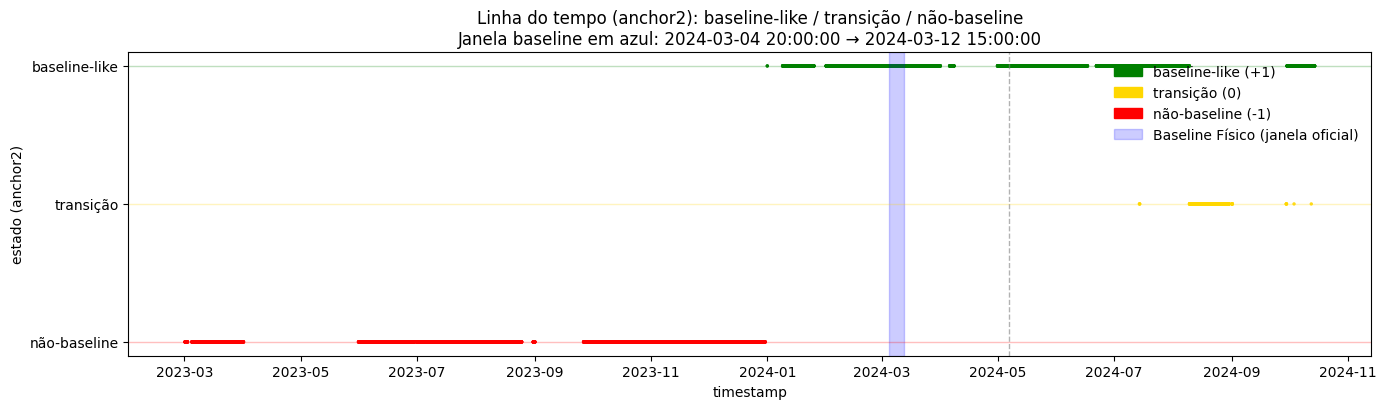

Figura salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\anchor2_timeline_baseline_band.png
Obs: ajuste BAND para mudar a largura da faixa de transição (ex.: 0.03 = ±3%).


In [28]:
# ============================================
# Timeline pelo critério físico (anchor2) com 3 cores
#  +1 (verde) = baseline-like
#   0 (amarelo) = transição (banda neutra)
#  -1 (vermelho) = não-baseline
# ============================================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_ANCH = os.path.join(FREEZE_DIR, "anchor2_labels.csv")
PATH_META = os.path.join(FREEZE_DIR, "anchor2_meta.json")
OUT_PNG   = os.path.join(FREEZE_DIR, "anchor2_timeline_baseline_band.png")

# --- banda neutra (±5% em torno do limiar razão==1.0)
BAND = 0.05

# --- carrega labels e meta
df = pd.read_csv(PATH_ANCH)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values("timestamp").reset_index(drop=True)

with open(PATH_META, "r", encoding="utf-8") as f:
    meta = json.load(f)
BASE_START = pd.to_datetime(meta["baseline_window"]["start"])
BASE_END   = pd.to_datetime(meta["baseline_window"]["end"])
CUT_VAL    = pd.Timestamp("2024-05-06 17:00:00")  # opcional (início validação)

# --- classificação por razão
dist_b = pd.to_numeric(df["dist_to_baseline"], errors="coerce").values
dist_o = pd.to_numeric(df["dist_to_other"],    errors="coerce").values
eps = 1e-12
ratio = dist_b / (dist_o + eps)

# classes: +1 (verde), 0 (amarelo), -1 (vermelho)
y = np.full(len(df), 0.0)  # start as transition
y[ratio <= (1.0 - BAND)] = +1.0   # baseline-like claro
y[ratio >= (1.0 + BAND)] = -1.0   # não-baseline claro

# cores
colors = np.where(y > 0.5, "green", np.where(y < -0.5, "red", "gold"))

# --- contagens
mask_base = (df["timestamp"] >= BASE_START) & (df["timestamp"] <= BASE_END)
def counts(vec):
    return {
        "+1 (baseline-like)": int((vec > 0.5).sum()),
        " 0 (transição)":     int((np.abs(vec) <= 0.5).sum()),
        "-1 (não-baseline)":  int((vec < -0.5).sum())
    }
print("Contagens GLOBAIS:", counts(y))
print("Contagens na janela BASELINE:", counts(y[mask_base]))

# --- plot
plt.figure(figsize=(14, 4.2))
plt.scatter(df["timestamp"], y, s=6, c=colors, alpha=0.9, linewidths=0)

# linhas guia
plt.axhline(+1.0, color="green",  linewidth=1, alpha=0.25)
plt.axhline( 0.0, color="gold",   linewidth=1, alpha=0.25)
plt.axhline(-1.0, color="red",    linewidth=1, alpha=0.25)

# faixa azul do baseline oficial
plt.axvspan(BASE_START, BASE_END, color="blue", alpha=0.20)

# linha de corte de validação (opcional)
plt.axvline(CUT_VAL, color="grey", linestyle="--", linewidth=1, alpha=0.6)

plt.yticks([-1, 0, 1], labels=["não-baseline", "transição", "baseline-like"])
plt.xlabel("timestamp")
plt.ylabel("estado (anchor2)")
plt.title(f"Linha do tempo (anchor2): baseline-like / transição / não-baseline\nJanela baseline em azul: {BASE_START} → {BASE_END}")

# legenda
legend_handles = [
    mpatches.Patch(color="green", label="baseline-like (+1)"),
    mpatches.Patch(color="gold",  label="transição (0)"),
    mpatches.Patch(color="red",   label="não-baseline (-1)"),
    mpatches.Patch(color="blue",  alpha=0.20, label="Baseline Físico (janela oficial)"),
]
plt.legend(handles=legend_handles, loc="upper right", frameon=False)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=160)
plt.show()

print("Figura salva em:", OUT_PNG)
print("Obs: ajuste BAND para mudar a largura da faixa de transição (ex.: 0.03 = ±3%).")


In [29]:
# ============================================================
# Anchor2 com MAHALANOBIS + Médias de Wr/Wm por fase (verde/amarelo/vermelho)
# ============================================================
import os, json, numpy as np, pandas as pd

FREEZE_DIR  = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_SCORES = os.path.join(FREEZE_DIR, "pca_scores.csv")           # precisa: timestamp, split, PC1..PCm
PATH_META   = os.path.join(FREEZE_DIR, "anchor2_meta.json")        # contém a janela baseline oficial
PATH_FEATS  = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")

OUT_LABELS  = os.path.join(FREEZE_DIR, "anchor2_labels_maha.csv")
OUT_MEANS   = os.path.join(FREEZE_DIR, "anchor2_phase_means_maha.csv")

# ----- parâmetros -----
BAND = 0.05        # banda neutra da razão (±5% -> amarelo)
RIDGE = 1e-6       # regularização proporcional na covariância (segurança numérica)

# 1) Carrega PCs e meta (janela do baseline)
scores = pd.read_csv(PATH_SCORES)
scores["timestamp"] = pd.to_datetime(scores["timestamp"], errors="coerce")
scores = scores.sort_values("timestamp").reset_index(drop=True)
pc_cols = [c for c in scores.columns if c.startswith("PC")]
assert len(pc_cols) > 0, "pca_scores.csv sem colunas PC*."

with open(PATH_META, "r", encoding="utf-8") as f:
    meta = json.load(f)
BASE_START = pd.to_datetime(meta["baseline_window"]["start"])
BASE_END   = pd.to_datetime(meta["baseline_window"]["end"])

mask_base = (scores["timestamp"] >= BASE_START) & (scores["timestamp"] <= BASE_END)
X  = scores[pc_cols].to_numpy(dtype=float, copy=False)
Xb = X[mask_base.values]
Xo = X[~mask_base.values]

# 2) Centróides e covariância do baseline
mu_base  = Xb.mean(axis=0)
mu_other = Xo.mean(axis=0) if len(Xo) else mu_base.copy()

# covariância do baseline + ridge (para estabilidade); usa pinv para a inversa
S = np.cov(Xb, rowvar=False)
# regularização proporcional à tr(S)/p
p = S.shape[0]
lam = RIDGE * float(np.trace(S)) / max(p, 1)
S_reg = S + lam * np.eye(p)
Sinv = np.linalg.pinv(S_reg)

def d_maha_batch(Xmat, mu, Sinv):
    D = Xmat - mu
    # (x - mu)^T S^-1 (x - mu) para cada linha
    return np.sqrt(np.einsum("ij,jk,ik->i", D, Sinv, D))

dist_b = d_maha_batch(X,  mu_base,  Sinv)
dist_o = d_maha_batch(X,  mu_other, Sinv)

# raio r95 no baseline (diagnóstico)
from numpy import quantile
r95_maha = float(quantile(d_maha_batch(Xb, mu_base, Sinv), 0.95))

# 3) Classificação por razão (verde/amarelo/vermelho)
eps = 1e-12
ratio = dist_b / (dist_o + eps)
phase_code = np.select([ratio <= 1.0 - BAND, ratio >= 1.0 + BAND], [1, -1], default=0)
phase_str  = np.where(phase_code== 1, "baseline_like",
              np.where(phase_code== 0, "transicao", "nao_baseline"))

# 4) Salva labels MAHA
out = scores[["timestamp","split"]].copy()
out["dist_base_maha"]  = dist_b
out["dist_other_maha"] = dist_o
out["ratio_maha"]      = ratio
out["baseline_r95_maha"] = r95_maha
out["phase_code"]      = phase_code       # +1 verde, 0 amarelo, -1 vermelho
out["phase"]           = phase_str
out.to_csv(OUT_LABELS, index=False, encoding="utf-8")

print("Labels MAHA salvos em:", OUT_LABELS)

# 5) Médias de Wr/Wm por fase (alinha com GOLD features)
#    -> o arquivo GOLD tem 2 cabeçalhos; usamos a linha de nomes (1ª)
dfr = pd.read_csv(PATH_FEATS, header=[0,1], engine="python")
dfg = dfr.copy(); dfg.columns = [c for (c,_) in dfr.columns]  # usa nomes
assert len(dfg) == len(out), "Alinhamento diferente entre GOLD e PCA/anchor2."

# pega Wr e Wm
wr = pd.to_numeric(dfg["wr_kg_m2_h"], errors="coerce")
wm = pd.to_numeric(dfg["wm_kg_m2_h"], errors="coerce")

res = (pd.DataFrame({"phase": out["phase"], "wr": wr, "wm": wm})
         .groupby("phase")
         .agg(n=("wr","size"),
              wr_mean=("wr","mean"),
              wm_mean=("wm","mean"),
              wr_std=("wr","std"),
              wm_std=("wm","std"))
         .reset_index())

# ordena fases na ordem desejada
phase_order = pd.Categorical(res["phase"], categories=["baseline_like","transicao","nao_baseline"], ordered=True)
res = res.assign(phase=phase_order).sort_values("phase").reset_index(drop=True)

res.to_csv(OUT_MEANS, index=False, encoding="utf-8")
print("Médias por fase salvas em:", OUT_MEANS)
display(res)


Labels MAHA salvos em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\anchor2_labels_maha.csv
Médias por fase salvas em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\anchor2_phase_means_maha.csv


,phase,n,wr_mean,wm_mean,wr_std,wm_std
0,baseline_like,5018,1.826013e-07,103305.547633,3.521284e-07,171847.035833
1,nao_baseline,4987,4.189743e-09,136.959414,4.151965e-08,4779.299602


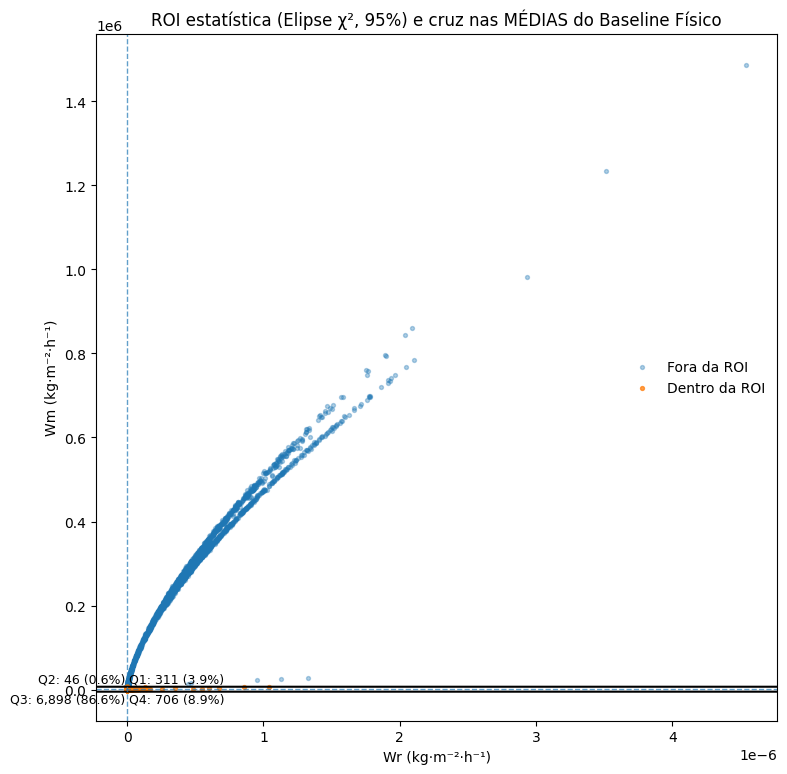

Figura salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\wr_wm_roi_baseline_means.png
Médias (baseline): Wr̄=0.000 | Wm̄=704.610


In [30]:
# ============================================================
# Scatter (Wr x Wm) com cruz nas MÉDIAS do Baseline Físico,
# ROI elíptica (χ² 95%) e quadrantes com contagem/%
# ============================================================
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# --- PATHS ---
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_META  = os.path.join(FREEZE_DIR, "anchor2_meta.json")  # opcional
OUT_PNG    = os.path.join(FREEZE_DIR, "wr_wm_roi_baseline_means.png")

# --- janela baseline (fallback se não houver meta) ---
BASE_START_FALLBACK = pd.Timestamp("2024-03-04 20:00:00")
BASE_END_FALLBACK   = pd.Timestamp("2024-03-12 15:00:00")

# --- Carrega GOLD (2 cabeçalhos) ---
dfr = pd.read_csv(PATH_FEATS, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
ts  = pd.to_datetime(df.iloc[:,0], errors="coerce")

# --- Alvos ---
wr = pd.to_numeric(df["wr_kg_m2_h"], errors="coerce").values
wm = pd.to_numeric(df["wm_kg_m2_h"], errors="coerce").values

# --- Meta baseline ---
if os.path.exists(PATH_META):
    with open(PATH_META, "r", encoding="utf-8") as f:
        meta = json.load(f)
    BASE_START = pd.to_datetime(meta["baseline_window"]["start"])
    BASE_END   = pd.to_datetime(meta["baseline_window"]["end"])
else:
    BASE_START, BASE_END = BASE_START_FALLBACK, BASE_END_FALLBACK

mask_base = (ts >= BASE_START) & (ts <= BASE_END)

# --- Médias do baseline (cruz) ---
wr_mu = float(np.nanmean(wr[mask_base]))
wm_mu = float(np.nanmean(wm[mask_base]))

# --- ROI estatística (χ² 95%) no baseline ---
XYb = np.vstack([wr[mask_base], wm[mask_base]]).T
# protege contra NaN/Inf
XYb = XYb[~np.isnan(XYb).any(axis=1) & ~np.isinf(XYb).any(axis=1)]
if XYb.shape[0] < 10:
    raise RuntimeError("Poucos pontos válidos no baseline para estimar a ROI.")

cov = np.cov(XYb, rowvar=False)
# regularização simples, se necessário
if np.linalg.cond(cov) > 1e10:
    lam = 1e-6 * np.trace(cov) / 2.0
    cov = cov + lam * np.eye(2)

vals, vecs = np.linalg.eigh(cov)               # autovalores (λ1≤λ2) e autovetores
order = np.argsort(vals)[::-1]                 # λmax primeiro
vals, vecs = vals[order], vecs[:,order]
chi2_val = chi2.ppf(0.95, df=2)                # 95%
# semi-eixos da elipse (em unidades do espaço Wr/Wm)
a = np.sqrt(vals[0] * chi2_val)                # semi-eixo maior
b = np.sqrt(vals[1] * chi2_val)                # semi-eixo menor
angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))

# --- Classifica pontos dentro/fora da ROI (Mahalanobis² ≤ χ²_0.95) ---
X = np.vstack([wr, wm]).T
# limpar
valid = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1)
Xv = X[valid]
mu_vec = np.array([wr_mu, wm_mu])
Sinv = np.linalg.pinv(cov)

d2 = np.einsum("ij,jk,ik->i", Xv - mu_vec, Sinv, Xv - mu_vec)
inside = np.zeros(len(X), dtype=bool)
inside[np.where(valid)[0]] = d2 <= chi2_val

# --- Quadrantes (apenas DENTRO da ROI) relativos às médias do baseline ---
Q = np.zeros(4, dtype=int)
idx_inside = np.where(inside)[0]
if len(idx_inside) > 0:
    Xi = X[idx_inside]
    q1 = (Xi[:,0] >= wr_mu) & (Xi[:,1] >= wm_mu)
    q2 = (Xi[:,0] <  wr_mu) & (Xi[:,1] >= wm_mu)
    q3 = (Xi[:,0] <  wr_mu) & (Xi[:,1] <  wm_mu)
    q4 = (Xi[:,0] >= wr_mu) & (Xi[:,1] <  wm_mu)
    Q = np.array([q1.sum(), q2.sum(), q3.sum(), q4.sum()])
    P = (Q / Q.sum() * 100.0).round(1)
else:
    P = np.zeros(4)

# --- Plot ---
plt.figure(figsize=(8, 8))

# pontos
plt.scatter(wr[~inside], wm[~inside], s=8, alpha=0.35, label="Fora da ROI")
plt.scatter(wr[ inside], wm[ inside], s=8, alpha=0.75, label="Dentro da ROI")

# cruz nas médias do baseline
plt.axvline(wr_mu, linestyle="--", linewidth=1, alpha=0.7)
plt.axhline(wm_mu, linestyle="--", linewidth=1, alpha=0.7)

# elipse da ROI
ell = Ellipse((wr_mu, wm_mu), width=2*a, height=2*b, angle=angle,
              fill=False, linewidth=1.5)
plt.gca().add_patch(ell)

# anotações de quadrantes (posições relativas)
dx = (np.nanpercentile(wr, 95) - np.nanpercentile(wr, 5)) * 0.02
dy = (np.nanpercentile(wm, 95) - np.nanpercentile(wm, 5)) * 0.02
plt.text(wr_mu+dx, wm_mu+dy,     f"Q1: {Q[0]:,} ({P[0]}%)", ha="left",  va="bottom", fontsize=9)
plt.text(wr_mu-dx, wm_mu+dy,     f"Q2: {Q[1]:,} ({P[1]}%)", ha="right", va="bottom", fontsize=9)
plt.text(wr_mu-dx, wm_mu-dy,     f"Q3: {Q[2]:,} ({P[2]}%)", ha="right", va="top",    fontsize=9)
plt.text(wr_mu+dx, wm_mu-dy,     f"Q4: {Q[3]:,} ({P[3]}%)", ha="left",  va="top",    fontsize=9)

plt.xlabel("Wr (kg·m⁻²·h⁻¹)")
plt.ylabel("Wm (kg·m⁻²·h⁻¹)")
plt.title("ROI estatística (Elipse χ², 95%) e cruz nas MÉDIAS do Baseline Físico")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=160)
plt.show()

print("Figura salva em:", OUT_PNG)
print(f"Médias (baseline): Wr̄={wr_mu:,.3f} | Wm̄={wm_mu:,.3f}")


[GOLD] shape: (10005, 147)
[splits] criados e salvos.
[pipeline] imputer/scaler treinados e salvos.

=== BASELINE RF (GOLD) ===
VAL: {'wr_kg_m2_h': {'R2': 0.9307405554581266, 'MAE': 5.371021186629064e-08}, 'wm_kg_m2_h': {'R2': 0.9251247772044555, 'MAE': 26756.001874138256}}
TST: {'wr_kg_m2_h': {'R2': 0.7555313839613604, 'MAE': 1.0838959098182045e-07}, 'wm_kg_m2_h': {'R2': 0.6977987427390622, 'MAE': 58664.26083089119}}
modelo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\rf_gold_20250818_0640.joblib
[SILVER2] shape: (11749, 147)  (use como conjunto de robustez)


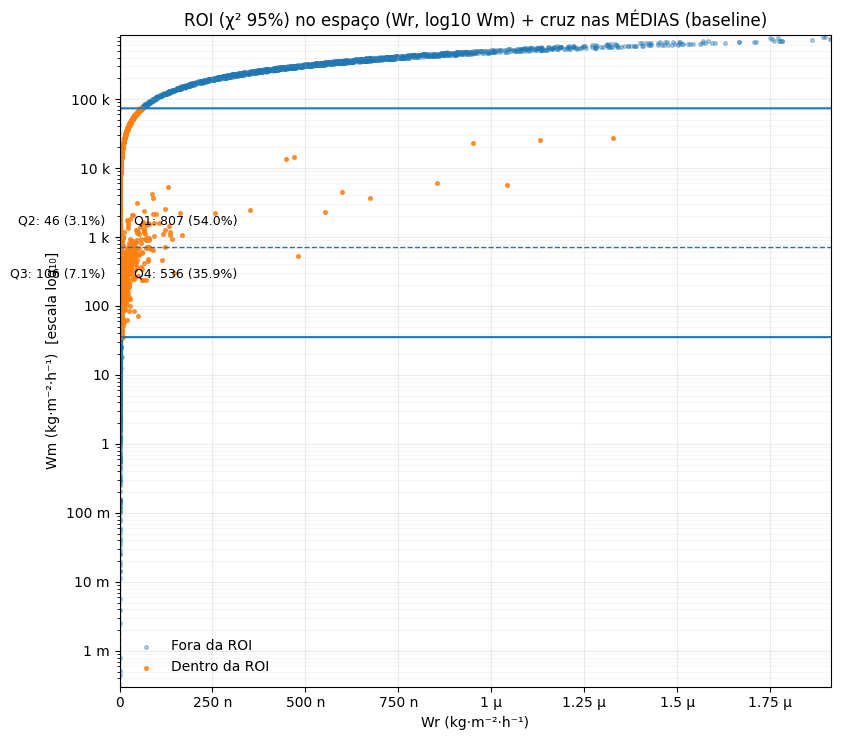

Figura salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\wr_wm_roi_baseline_means_logy.png
Médias do baseline (lineares): Wr̄=0.000 | Wm̄=704.610


In [31]:
# ============================================================
# Wr x Wm com Y em log10, cruz nas MÉDIAS (lineares) do baseline
# e ROI (χ² 95%) calculada no espaço (Wr, log10 Wm)
# ============================================================
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, LogLocator, AutoMinorLocator
from scipy.stats import chi2

# ---- Parâmetros ----
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
PATH_META  = os.path.join(FREEZE_DIR, "anchor2_meta.json")   # contém a janela baseline
OUT_PNG    = os.path.join(FREEZE_DIR, "wr_wm_roi_baseline_means_logy.png")

LOG_Y = "log10"         # 'log10' para Wm (recomendado)
PERC_LIMS = (0.1, 99.9) # recorte de eixos (percentis) para melhor visualização
RIDGE = 1e-6            # pequena regularização da covariância do baseline

# ---- Carrega GOLD (2 cabeçalhos) ----
dfr = pd.read_csv(PATH_FEATS, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
ts  = pd.to_datetime(df.iloc[:,0], errors="coerce")
wr  = pd.to_numeric(df["wr_kg_m2_h"], errors="coerce").values
wm  = pd.to_numeric(df["wm_kg_m2_h"], errors="coerce").values

# ---- Janela do baseline ----
if os.path.exists(PATH_META):
    with open(PATH_META, "r", encoding="utf-8") as f:
        meta = json.load(f)
    BASE_START = pd.to_datetime(meta["baseline_window"]["start"])
    BASE_END   = pd.to_datetime(meta["baseline_window"]["end"])
else:
    BASE_START = pd.Timestamp("2024-03-04 20:00:00")
    BASE_END   = pd.Timestamp("2024-03-12 15:00:00")

mask_base = (ts >= BASE_START) & (ts <= BASE_END)

# ---- Médias (lineares) do baseline para a CRUZ ----
wr_mu_lin = float(np.nanmean(wr[mask_base]))
wm_mu_lin = float(np.nanmean(wm[mask_base]))

# ---- Transformação para o espaço do GRÁFICO: y = log10(Wm) ----
#     (descarta pontos com Wm<=0 para a ROI; eles ainda são plotados, mas "fora da ROI")
eps = 1e-12
wm_pos_mask = (wm > 0)
y_log = np.full_like(wm, np.nan, dtype=float)
y_log[wm_pos_mask] = np.log10(wm[wm_pos_mask])

# baseline no espaço transformado
base_valid = mask_base & wm_pos_mask
Wr_b = wr[base_valid];  Y_b = y_log[base_valid]
assert len(Wr_b) >= 10, "Poucos pontos válidos no baseline (Wm>0) para estimar a ROI."

# ---- ROI (χ² 95%) no espaço (Wr, log10 Wm) ----
XYb = np.vstack([Wr_b, Y_b]).T
mu_tr = XYb.mean(axis=0)

S = np.cov(XYb, rowvar=False)
if np.linalg.cond(S) > 1e10:
    lam = RIDGE * np.trace(S) / 2.0
    S = S + lam * np.eye(2)
Sinv = np.linalg.pinv(S)
chi2_val = chi2.ppf(0.95, df=2)

# distância de Mahalanobis² no espaço transformado
def maha2(X, mu, Sinv):
    D = X - mu
    return np.einsum("ij,jk,ik->i", D, Sinv, D)

# pontos válidos para classificar dentro/fora ROI
valid_all = wm_pos_mask & np.isfinite(wr) & np.isfinite(y_log)
XYv = np.vstack([wr[valid_all], y_log[valid_all]]).T
d2  = maha2(XYv, mu_tr, Sinv)
inside = np.zeros(len(wr), dtype=bool)
inside[np.where(valid_all)[0]] = d2 <= chi2_val

# ---- Quadrantes (apenas DENTRO da ROI), relativos às MÉDIAS LINEARES ----
idx_in = np.where(inside)[0]
Q = np.zeros(4, dtype=int)
if len(idx_in):
    Xi_wr = wr[idx_in]; Xi_wm = wm[idx_in]
    q1 = (Xi_wr >= wr_mu_lin) & (Xi_wm >= wm_mu_lin)
    q2 = (Xi_wr <  wr_mu_lin) & (Xi_wm >= wm_mu_lin)
    q3 = (Xi_wr <  wr_mu_lin) & (Xi_wm <  wm_mu_lin)
    q4 = (Xi_wr >= wr_mu_lin) & (Xi_wm <  wm_mu_lin)
    Q = np.array([q1.sum(), q2.sum(), q3.sum(), q4.sum()])
    P = (Q / Q.sum() * 100.0).round(1)
else:
    P = np.zeros(4)

# ---- Limites de eixos por percentis ----
xlo, xhi = np.nanpercentile(wr, PERC_LIMS)
# para Y em log: limites em Wm (lineares), depois aplicados ao eixo log
wm_pos = wm[wm_pos_mask]
if len(wm_pos) >= 10:
    ylo, yhi = np.nanpercentile(wm_pos, PERC_LIMS)
else:
    ylo, yhi = np.nanmin(wm_pos), np.nanmax(wm_pos)
ylo = max(ylo, eps)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8.5, 7.5))

# Scatter: fora e dentro da ROI (cores default do Matplotlib)
ax.scatter(wr[~inside], wm[~inside], s=7, alpha=0.35, label="Fora da ROI")
ax.scatter(wr[ inside], wm[ inside], s=7, alpha=0.80, label="Dentro da ROI")

# Cruz nas MÉDIAS (lineares) do baseline
ax.axvline(wr_mu_lin, linestyle="--", linewidth=1)
ax.axhline(wm_mu_lin, linestyle="--", linewidth=1)

# Eixo Y log10
ax.set_yscale("log")
ax.set_ylim(ylo, yhi)
ax.set_xlim(xlo, xhi)

# Tick format (SI)
ax.xaxis.set_major_formatter(EngFormatter(unit=""))
ax.yaxis.set_major_formatter(EngFormatter(unit=""))

# Grade (major e minor)
ax.grid(True, which="major", alpha=0.25)
ax.grid(True, which="minor", alpha=0.12)
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10)*0.1))

# Elipse da ROI no espaço transformado → parametrize e plote como curva
# (gera bem mesmo com escala log no y, pois calculamos no espaço (Wr, log10 Wm))
w, v = np.linalg.eigh(S)
order = np.argsort(w)[::-1]
w, v = w[order], v[:,order]
theta = np.linspace(0, 2*np.pi, 400)
# elipse no espaço transformado
a = np.sqrt(w[0]*chi2_val); b = np.sqrt(w[1]*chi2_val)
el_tr = mu_tr + np.column_stack([a*np.cos(theta), b*np.sin(theta)]) @ v.T
# volta para o espaço de plot: (Wr, Wm) com Wm = 10^(y_log)
el_wr = el_tr[:,0]
el_wm = np.power(10.0, el_tr[:,1])
ax.plot(el_wr, el_wm, linewidth=1.5)

# Anotações de quadrantes
dx = (xhi - xlo)*0.02
dy = (np.log10(yhi) - np.log10(ylo))*0.03  # deslocamento proporcional em log
ax.text(wr_mu_lin+dx, wm_mu_lin*np.power(10,  dy), f"Q1: {Q[0]:,} ({P[0]}%)", ha="left",  va="bottom", fontsize=9)
ax.text(wr_mu_lin-dx, wm_mu_lin*np.power(10,  dy), f"Q2: {Q[1]:,} ({P[1]}%)", ha="right", va="bottom", fontsize=9)
ax.text(wr_mu_lin-dx, wm_mu_lin/np.power(10,  dy), f"Q3: {Q[2]:,} ({P[2]}%)", ha="right", va="top",    fontsize=9)
ax.text(wr_mu_lin+dx, wm_mu_lin/np.power(10,  dy), f"Q4: {Q[3]:,} ({P[3]}%)", ha="left",  va="top",    fontsize=9)

ax.set_xlabel("Wr (kg·m⁻²·h⁻¹)")
ax.set_ylabel("Wm (kg·m⁻²·h⁻¹)  [escala log₁₀]")
ax.set_title("ROI (χ² 95%) no espaço (Wr, log10 Wm) + cruz nas MÉDIAS (baseline)")
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(OUT_PNG, dpi=160)
plt.show()

print("Figura salva em:", OUT_PNG)
print(f"Médias do baseline (lineares): Wr̄={wr_mu_lin:,.3f} | Wm̄={wm_mu_lin:,.3f}")


In [32]:
# ============================================================
# Procurar janelas estáveis "mínimas" para (Wr, Wm) como par:
#   Regra: Wr <= pWr e Wm <= pWm (padrão pWr=pWm=5º percentil)
#   Saída: todas as sequências contíguas que obedecem à regra,
#          com início/fim, n, duração e estatísticas de Wr/Wm.
# ============================================================
import os, numpy as np, pandas as pd
from datetime import timedelta

# ---------- PARÂMETROS ----------
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")

P_WR = 5.0   # percentil alvo para Wr
P_WM = 5.0   # percentil alvo para Wm
MIN_LEN = 1  # comprimento mínimo da sequência (amostras)
TOL_GAPS = 0 # tolerância para “buracos” entre pontos True (0 = estritamente contígua).
             # Ex.: se TOL_GAPS=1, uma sequência pode ter gaps de até 1 amostra sem quebrar.

OUT_CSV = os.path.join(FREEZE_DIR, f"low_wr_wm_sequences_p{int(P_WR)}p{int(P_WM)}.csv")

# ---------- LOAD ----------
dfr = pd.read_csv(PATH_FEATS, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
ts  = pd.to_datetime(df.iloc[:,0], errors="coerce")
wr  = pd.to_numeric(df["wr_kg_m2_h"], errors="coerce")
wm  = pd.to_numeric(df["wm_kg_m2_h"], errors="coerce")

# ---------- LIMIAR GLOBAL ----------
thr_wr = float(np.nanpercentile(wr, P_WR))
thr_wm = float(np.nanpercentile(wm, P_WM))
mask = (wr <= thr_wr) & (wm <= thr_wm)

# ---------- SEQUÊNCIAS CONTÍGUAS ----------
idx_true = np.where(mask.values)[0]

def split_sequences(indices, tol_gaps=0):
    if len(indices) == 0: return []
    groups = []
    start = indices[0]; prev = indices[0]
    for k in indices[1:]:
        if k - prev - 1 > tol_gaps:
            groups.append((start, prev))
            start = k
        prev = k
    groups.append((start, prev))
    return groups

groups = split_sequences(idx_true, TOL_GAPS)

# ---------- ESTATÍSTICAS POR SEQUÊNCIA ----------
dt_median = (ts - ts.shift()).median()
rows = []
for (a,b) in groups:
    n = b - a + 1
    if n < MIN_LEN:
        continue
    seg_wr = wr.iloc[a:b+1]
    seg_wm = wm.iloc[a:b+1]
    start_ts = ts.iloc[a]
    end_ts   = ts.iloc[b]
    # duração "fechando a janela": end-start + passo_médio
    dur = (end_ts - start_ts) + (dt_median if pd.notna(dt_median) else timedelta(0))
    rows.append({
        "start_idx": int(a),
        "end_idx":   int(b),
        "n":         int(n),
        "start_ts":  str(start_ts),
        "end_ts":    str(end_ts),
        "duration":  str(dur),
        "wr_mean":   float(seg_wr.mean()),
        "wr_min":    float(seg_wr.min()),
        "wr_max":    float(seg_wr.max()),
        "wm_mean":   float(seg_wm.mean()),
        "wm_min":    float(seg_wm.min()),
        "wm_max":    float(seg_wm.max()),
    })

res = pd.DataFrame(rows).sort_values(["n","start_ts"], ascending=[False, True]).reset_index(drop=True)
res.to_csv(OUT_CSV, index=False, encoding="utf-8")

# ---------- RELATÓRIO ----------
print(f"Limiar Wr (p{P_WR}): {thr_wr:,.6f}")
print(f"Limiar Wm (p{P_WM}): {thr_wm:,.6f}")
print(f"Pontos no fundo simultâneo: {mask.sum()} de {len(mask)} ({mask.mean()*100:.2f}%)")
print(f"Sequências encontradas: {len(res)}  |  Arquivo: {OUT_CSV}")

print("\nTOP-10 sequências mais longas:")
display(res.head(10))

# SUGESTÃO DE NOVO BASELINE ESTÁVEL = sequência mais longa
if not res.empty:
    top = res.iloc[0].to_dict()
    print("\n==> SUGESTÃO DE NOVO PERÍODO ESTÁVEL (Wr&Wm mínimos) <==")
    print(f"Início:   {top['start_ts']}")
    print(f"Fim:      {top['end_ts']}")
    print(f"Amostras: {top['n']}  |  Duração: {top['duration']}")
    print(f"Wr̄={top['wr_mean']:,.3f}  (min={top['wr_min']:,.3f}, max={top['wr_max']:,.3f})")
    print(f"Wm̄={top['wm_mean']:,.3f}  (min={top['wm_min']:,.3f}, max={top['wm_max']:,.3f})")
else:
    print("Nenhuma sequência encontrada com esses limiares. Considere aumentar percentis (ex.: p10) ou TOL_GAPS.")


Limiar Wr (p5.0): 0.000000
Limiar Wm (p5.0): 0.000000
Pontos no fundo simultâneo: 6509 de 10005 (65.06%)
Sequências encontradas: 508  |  Arquivo: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\low_wr_wm_sequences_p5p5.csv

TOP-10 sequências mais longas:


,start_idx,end_idx,n,start_ts,end_ts,duration,wr_mean,wr_min,wr_max,wm_mean,wm_min,wm_max
0,5773,6072,300,2024-02-16 23:00:00,2024-02-29 16:00:00,12 days 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,5383,5611,229,2024-01-25 12:00:00,2024-02-10 05:00:00,15 days 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,3589,3814,226,2023-11-01 23:00:00,2023-11-11 10:00:00,9 days 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,3146,3368,223,2023-10-14 12:00:00,2023-10-23 18:00:00,9 days 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2458,2661,204,2023-08-14 15:00:00,2023-08-23 10:00:00,8 days 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0
5,2763,2938,176,2023-09-28 00:00:00,2023-10-05 15:00:00,7 days 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0
6,1383,1548,166,2023-06-29 10:00:00,2023-07-07 17:00:00,8 days 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0
7,4455,4616,162,2023-12-08 20:00:00,2023-12-15 13:00:00,6 days 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0
8,3373,3532,160,2023-10-23 23:00:00,2023-10-30 14:00:00,6 days 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0
9,2945,3092,148,2023-10-05 22:00:00,2023-10-12 06:00:00,6 days 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0



==> SUGESTÃO DE NOVO PERÍODO ESTÁVEL (Wr&Wm mínimos) <==
Início:   2024-02-16 23:00:00
Fim:      2024-02-29 16:00:00
Amostras: 300  |  Duração: 12 days 18:00:00
Wr̄=0.000  (min=0.000, max=0.000)
Wm̄=0.000  (min=0.000, max=0.000)


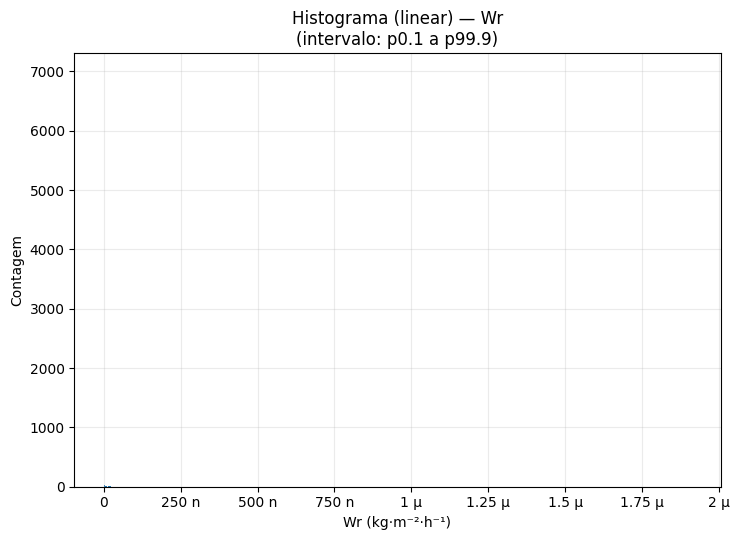

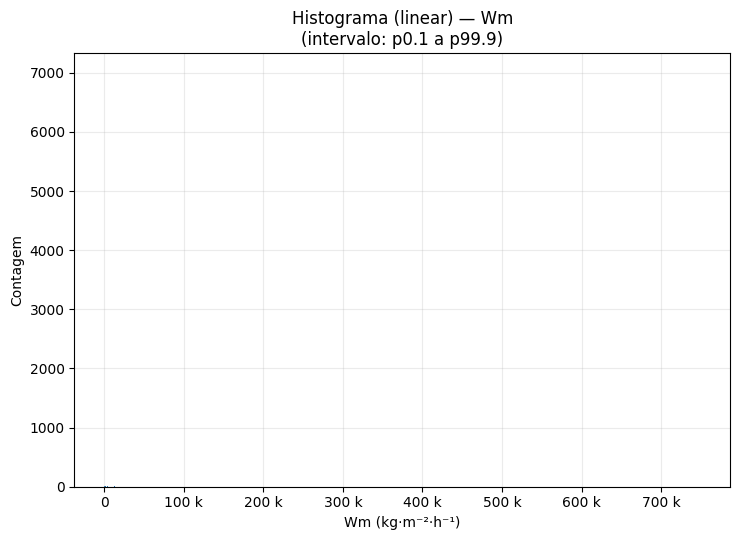

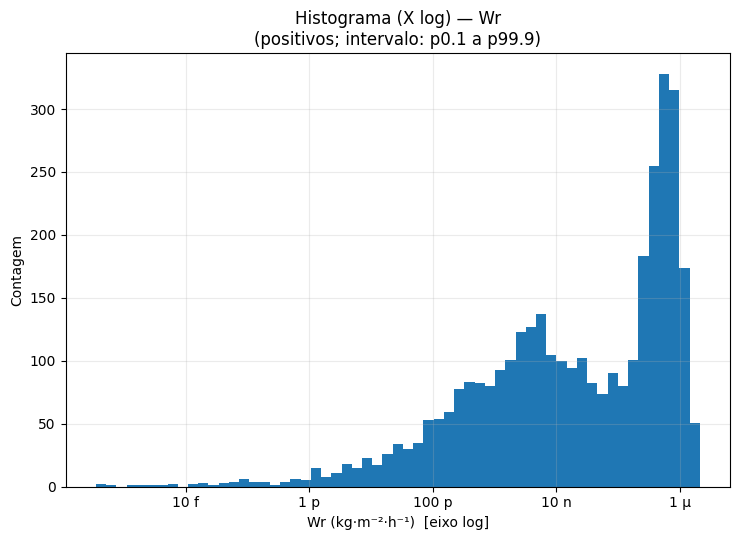

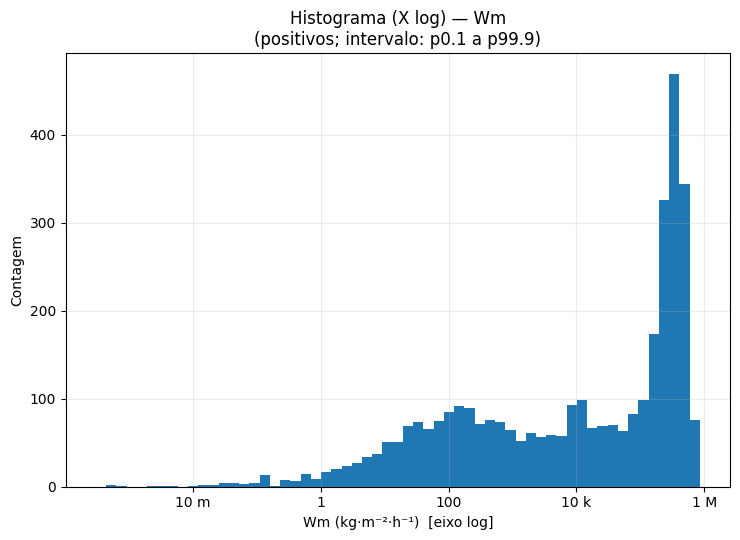

Arquivos salvos:
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\hist_wr_linear.png
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\hist_wm_linear.png
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\hist_wr_logx.png
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\hist_wm_logx.png
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\wr_wm_summary.csv


In [33]:
# ============================================
# HISTOGRAMAS de Wr e Wm (linear e log-x) + resumo numérico
# ============================================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

# ---- paths
FREEZE_DIR = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635"
PATH_FEATS = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
OUT_WR_LIN = os.path.join(FREEZE_DIR, "hist_wr_linear.png")
OUT_WM_LIN = os.path.join(FREEZE_DIR, "hist_wm_linear.png")
OUT_WR_LOG = os.path.join(FREEZE_DIR, "hist_wr_logx.png")
OUT_WM_LOG = os.path.join(FREEZE_DIR, "hist_wm_logx.png")
OUT_SUM    = os.path.join(FREEZE_DIR, "wr_wm_summary.csv")

# ---- load
dfr = pd.read_csv(PATH_FEATS, header=[0,1], engine="python")
df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
wr = pd.to_numeric(df["wr_kg_m2_h"], errors="coerce")
wm = pd.to_numeric(df["wm_kg_m2_h"], errors="coerce")

def describe_series(x: pd.Series, name: str):
    a = x.dropna().values
    n = a.size
    n_zero = int((a == 0).sum())
    n_neg  = int((a < 0).sum())
    percs = [0,1,5,10,25,50,75,90,95,99,99.9,100]
    pv = np.percentile(a, percs)
    pos = a[a > 0]
    if pos.size > 0:
        pv_pos = np.percentile(pos, percs)
    else:
        pv_pos = np.full_like(percs, np.nan, dtype=float)
    return {
        "name": name, "n": int(n), "zeros": n_zero, "negativos": n_neg,
        **{f"p{p}": float(v) for p,v in zip(percs, pv)},
        **{f"p{p}_posOnly": float(v) for p,v in zip(percs, pv_pos)}
    }

sum_wr = describe_series(wr, "wr_kg_m2_h")
sum_wm = describe_series(wm, "wm_kg_m2_h")
pd.DataFrame([sum_wr, sum_wm]).to_csv(OUT_SUM, index=False)

# ---- histogramas (linear) com recorte por percentil para legibilidade
def plot_linear(x, title, out_png):
    a = x.dropna().values
    # recorte nos percentis 0.1 e 99.9 para evitar caudas extremas dominarem a escala
    lo, hi = np.percentile(a, [0.1, 99.9])
    a_clip = a[(a >= lo) & (a <= hi)]
    plt.figure(figsize=(7.5, 5.5))
    plt.hist(a_clip, bins="auto")
    plt.xlabel(title + " (kg·m⁻²·h⁻¹)")
    plt.ylabel("Contagem")
    plt.title(f"Histograma (linear) — {title}\n(intervalo: p0.1 a p99.9)")
    plt.gca().xaxis.set_major_formatter(EngFormatter(unit=""))
    plt.grid(True, alpha=0.25)
    plt.tight_layout(); plt.savefig(out_png, dpi=150); plt.show()

plot_linear(wr, "Wr", OUT_WR_LIN)
plot_linear(wm, "Wm", OUT_WM_LIN)

# ---- histogramas (x em log10) — apenas positivos
def plot_logx(x, title, out_png):
    pos = x[(x > 0) & x.notna()].values
    if pos.size < 10:
        print(f"[Aviso] Poucos valores positivos para {title}; pulando log-x.")
        return
    # bins log-espaciados entre p0.1 e p99.9 dos positivos
    lo, hi = np.percentile(pos, [0.1, 99.9])
    lo = max(lo, np.nextafter(0, 1))  # garante > 0
    edges = np.logspace(np.log10(lo), np.log10(hi), 60)
    plt.figure(figsize=(7.5, 5.5))
    plt.hist(pos, bins=edges)
    plt.xscale("log")
    plt.xlabel(title + " (kg·m⁻²·h⁻¹)  [eixo log]")
    plt.ylabel("Contagem")
    plt.title(f"Histograma (X log) — {title}\n(positivos; intervalo: p0.1 a p99.9)")
    plt.gca().xaxis.set_major_formatter(EngFormatter(unit=""))
    plt.grid(True, which="both", alpha=0.25)
    plt.tight_layout(); plt.savefig(out_png, dpi=150); plt.show()

plot_logx(wr, "Wr", OUT_WR_LOG)
plot_logx(wm, "Wm", OUT_WM_LOG)

print("Arquivos salvos:")
print(" -", OUT_WR_LIN)
print(" -", OUT_WM_LIN)
print(" -", OUT_WR_LOG)
print(" -", OUT_WM_LOG)
print(" -", OUT_SUM)
